# Generative modelling in deep learning

*This notebook consists of common introductory questions, followed by 4 different generative models, and a common conclusive question. **Choose & implement 2 among the 4 models**, not all of them! If you train more models, write down below the 2 ones you want to be graded on. Do not forget the last common question.*

Generative modelling in machine learning can aim at achieving different goals.

The first, obvious one is that a generative model can be used to generate more data, to be used afterwards by another algorithm. While a generative model cannot create more information to solve the issue of having too small datasets, it could be used to solve anonymity questions. Typically, sharing a generative model trained on private data could allow the exploitation of the statistical property of this data without sharing the data itself (which can be protected by privacy matters for example).

Another goal is to use generative modelling to better understand the data at hand. This is based on the hypothesis that a model that successfully learned to generate (and generalize) a dataset should have internally learned some efficient and compressed representation of the information contained in the data. In this case, analysing a posteriori the learned representation may give us insights on the data itself.

The notion of a generative model however needs to be more formally specified, in order to work with. What does it mean for the model to generate data that "looks like" the original dataset? A mathematical formulation of that is necessary, in order to define a training objective that can be used efficiently. Having some expert rate the quality of all generated datapoints one by one is definitely not an option.

Thus, modelling our data and models as probability distributions comes to the rescue. If we consider our data as coming from some underlying probability distribution, that we will name $p_D$, our goal is thus to train our model to represent another probability distribution, which we will name $p_\theta$, that should be some good approximation of $p_D$. Given that we only know $p_D$ through some set of realisations from it (the dataset), we can never hope to learn it exactly.

**Q1: Can you name some metrics that can be used to compare two given distributions $p_D$ and $p_\theta$?**

We can name three different metrics:
- Kullback-Leibler Divergence: Even though it cannot be defined as a distance (non-symetric and does not verify the triangle inequality), this metric is widely use to compare two distributions. It quantifies info loss when moving from $P$ to $Q$ and for continous probabilities it can be expressed as:
$$D_{KL}(p_D||p_\theta) = \int p_D(x) \log(\frac{p_D(x)}{p_\theta(x)}) dx$$
- Kolmogorov-Smirnov Test: It is known as a test statistic to asses whether two samples are coming from the same distribution but it can also be used as a metric to measure the similarity bewteen two distributions. Given the cumulative distributions $F_D$ and $F_\theta$ of $p_D$ and $p\theta$ respectively it can be expressed as:
$$D_{KS}(p_D, p_\theta) = max(|F_D(x) - F_\theta(x)|)$$
- Jensen-Shannon Divergence: It is pretty similar to the KL-Divergence as it can be expressed as the average of the KL-Divergence between the average of the two given distributions with each one:
$$D_{JS}(p_D||p_\theta) = \frac{1}{2} (D_{KL}(p_D||M) + D_{KL}(p_\theta||M))$$
where $$M = \frac{1}{2} (p_D + p_\theta)$$

Most comparison methods can be separated into two kinds: those that compare the density of the distributions ($p_\theta(x)$ vs $p_D(x)$), and those that compare the values sampled from them. These two kinds of approaches have different behavior and trade-offs.

**Q2: Given we want to use them as an optimisation objective, what are the caveats to keep in mind about these two kinds?**

- For the first kind of metrics, comparing the density of the distributions, we have to keep in mind that we do not have access to the real ground truth distributions and can only approximate them thanks to the observations we observe. For some dsitributions with heavy tails or high variability it can thus be challenging. Additionnaly, in order to approximate the distributions we would have to: either choose a parametric approach and then choose a specific family of distributions that might not underlined the true one we have, or choose a non-parametric approach that is computationally expensive.

- The second kind of metrics highly depend on the number of data and whether or not is is representative enough of the true distributions. However it might gain the advantage of being non-parametric as opposed to the first kind with parametric approaches, which is what is commonly done.

In this work, we will focus on the most widely used generative models based on deep neural networks: Generative Adversarial Networks (GAN), Variational AutoEncoders (VAE), Normalizing Flows and Diffusion Models, in order to compare them and understand their strengths and weaknesses.

### Dataset

#### Checkerboard (prioritize this dataset)

In [1]:
import torch
import math
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt

def generate_batch(num_datapoints: int) -> np.ndarray:
  """Checkerboard dataset."""
  x1 = np.random.rand(num_datapoints) * 4 - 2
  x2 = np.random.rand(num_datapoints) - np.random.randint(0, 2, [num_datapoints]) * 2. + np.floor(x1) % 2
  data = np.stack([x1, x2]).T * 2
  data = (data - data.mean(axis=0)) / data.std(axis=0) # normalize
  return torch.from_numpy(data.astype(np.float32))

train_data = generate_batch(5000)

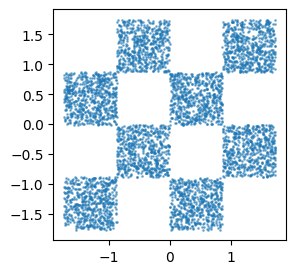

In [2]:
plt.figure(figsize=(3, 3))
plt.scatter(train_data.numpy()[:,0], train_data.numpy()[:,1], s=1.0, alpha=0.5)
plt.show()

It's also good to visualize the density as sometimes generative models overfit particular region of space. Once models are trained, when you sample from them, plot the two densities side-by-side to compare real & synthetic dataset.

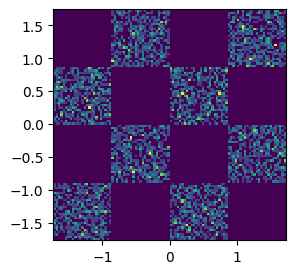

In [3]:
plt.figure(figsize=(3, 3))
plt.hist2d(train_data.numpy()[:,0], train_data.numpy()[:,1], bins=100)
plt.show()

#### Moon (use this one only if your models struggle on checkerboard)

In [4]:
import torch
import math
from sklearn import datasets
import numpy as np

# Our dataset is mathematically defined, we can generate batches on the fly and enjoy
# an infinite-size dataset
def generate_batch(batchlen):
    """This function generates a batch of length 'batchlen' from the dataset
    """
    data = datasets.make_moons(n_samples=batchlen, noise=0.05)[0].astype(np.float32)
    return torch.from_numpy(data)

Let's plot a large batch, to see what the dataset looks like.

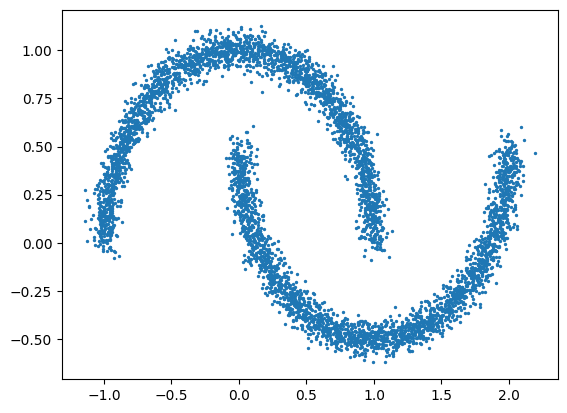

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

batch = generate_batch(5000)

plt.scatter(batch[:,0], batch[:,1], s=2.0)
plt.show()

It's also good to visualize the density as sometimes generative models overfit particular areas. Once models are trained, when you sample from them, plot the two densities side-by-side to compare real & synthetic dataset.

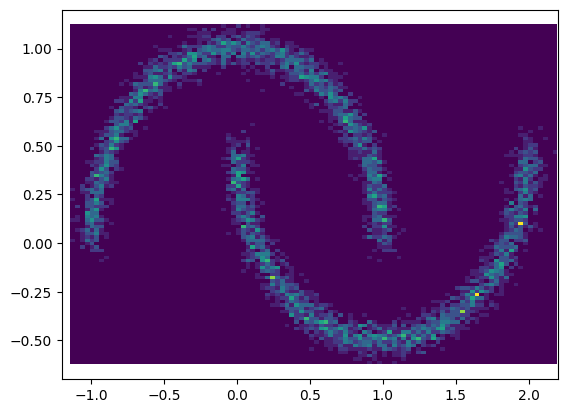

In [6]:
plt.hist2d(batch.numpy()[:,0], batch.numpy()[:,1], bins=100)
plt.xlim([-1.2,2.2])
plt.ylim([-0.7,1.2])
plt.show()

----
### Generative Adversarial Networks

GANs structure is based on modelling the distribution $p_\theta$ as a learned deterministic function applied to a standard noise. Sampling from it is thus done as follows: first, some noise is sampled from a standard N-dimensional Gaussian distribution: $\epsilon \sim \mathcal{N}(0;I)$, and then the output is computed as a deterministic function $x = f_\theta(\epsilon)$. The function $f_\theta$ is implemented as a neural network, $\theta$ representing its learned parameters.

**Q3: What is, a priori, the impact of the choice of N, the dimension of the input noise $\epsilon$?**

> (Write your answer here)

By construction, this generator structure only allows sampling the distribution $p_\theta$, and does not allow the computation of the density $p_\theta(x)$ (at least not without strong assumptions on $f_\theta$). Such a model thus needs a comparison method based on samples to be trained.

The smart idea of GANs is to instead use another neural network to model the objective. Another neural network is introduced: a classifier (that we call the discriminator) which is trained to distinguish examples from the dataset from examples generated by $p_\theta$. The reasoning is as follows:

The discriminator $D$ is trained using a classic classifier loss between the two classes defined as the samples generated by either $p_D$ or $p_\theta$. This way $D(x)$ can be interpreted as the probability that $x$ came from the real dataset:

$$ \mathcal{L}_D = \mathbb{E}_{p_D} \left[ -\log D(x) \right] + \mathbb{E}_{p_\theta} \left[ -\log \left(1-D(x)\right) \right] $$

From that, it can be shown that for the generator fixed, the optimal discriminator is given by $D(x) = \frac{p_D(x)}{p_\theta(x) + p_D(x)}$, and when reached its loss takes a specific value:

$$ \mathcal{L}_D = 2 \left( \log 2 - JSD(p_\theta \| p_D) \right) $$
, where JSD is the JS divergence used to measure the similarity of two distributions.
$$JSD(p_\theta \| p_D) = \frac{1}{2} \mathbb{E}_{p_D} \left[ log(\frac{2p_D}{p_D+p_\theta}) \right] + \frac{1}{2} \mathbb{E}_{p_\theta} \left[ log(\frac{2p_\theta}{p_D+p_\theta}) \right]$$
So, training the generator network to *maximize* the same loss would, assuming the discriminator is always trained to optimality, minimize the Jensen-Shannon Divergence between $p_\theta$ and $p_D$, and thus bring $p_\theta$ closer to $p_D$.

**Q4: Can you anticipate a caveat of using the JSD as a training objective for the generator?**

> (Write your answer here, consider the case where the two distribution are totally different)

Having the generator trained to maximize $\mathcal{L}_D$ is equivalent to setting its training loss to $ \mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x)) $.

**Q5: This loss only gives feedback to the generator on samples it generated, what problem may this cause?**

> (Write your answer here)

We will now work on implementing a GAN on a simple toy problem, to get a feeling of its behavior and test our theoretical insights. For this we will use the `pytorch` library.

While a real problem would be generating images for example (each datapoint $x$ would then be a different image), this is a kind of task that easily requires intensive CPU/GPU power, and image datasets are difficult to visualize from a geometric point of view (even small images contains hundreds of pixels, and nobody can visualize points in a 100-dimensional space). So instead we will focus on points in the plane: each datapoint $x$ will actually be a couple of numbers $(x1, x2)$, and our target dataset will be a 2D two-moons shape with some noise.

We now need to define our two neural networks, the generator and the discriminator. The generator will take as input a value $z$ sampled from a Gaussian prior, and output a value $x$ (thus a couple $(x_1,x_2)$). The discriminator takes as input a value $x$, and is a binary classifier.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Choose a value for the prior dimension
PRIOR_N = 2

# Define the generator
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(PRIOR_N, 2)

    def __call__(self, z):
        return self.fc1(z)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, PRIOR_N), 1.0)
        return self.__call__(z)


# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 1)

    def __call__(self, x):
        return self.fc1(x)

With these classes in shape, now is only needed the training loop. To stick with the mathematical GAN framework, we should train the discriminator until convergence between each training step of the generator. This is not practical for two reasons: first it takes a lot of time, and second if the discriminator is too good, it will generate vanishing gradients to the generator (as seen in **Q4**).

We will thus train the discriminator a fixed number of times between each training iteration of the generator.

In [ ]:
# Number of times to train the discriminator between two generator steps
TRAIN_RATIO = 1
# Total number of training iterations for the generator
N_ITER = 20001
# Batch size to use
BATCHLEN = 128

generator = Generator()
optim_gen = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5,0.9))
discriminator = Discriminator()
optim_disc = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    # train the discriminator
    for _ in range(TRAIN_RATIO):
        discriminator.zero_grad()
        real_batch = generate_batch(BATCHLEN)
        fake_batch = generator.generate(BATCHLEN)
        #
        # == COMPUTE THE DISCRIMINATOR LOSS HERE ==
        #
        disc_loss = 0
        disc_loss.backward()
        optim_disc.step()
    # train the generator
    generator.zero_grad()
    fake_batch = generator.generate(BATCHLEN)
    #
    # == COMPUTE THE GENERATOR LOSS HERE
    #
    gen_loss = 0
    gen_loss.backward()
    optim_gen.step()
    if i%1000 == 0:
        print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
        # plot the result
        real_batch = generate_batch(1024)
        fake_batch = generator.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

AttributeError: 'int' object has no attribute 'backward'

Complete the previous code and train your model.

Depending on your choice of parameters, the training may not go well at all, with the generator completely collapsing quickly at the beginning of the training. It has been observed by the litterature that the generator's loss $\mathcal{L}_G = \mathbb{E}_{p_\theta} \log(1-D(x))$ is often to blame.

**Q6: Why could we anticipate that this loss could cause this?**

> (Write your answer here, consider about gradient vanishing when discriminator is trained very well)

This issue is solved by replacing the generator loss by an alternative loss: $\mathcal{L}_G = \mathbb{E}_{p_\theta} [ -\log D(x) ]$ to avoid gradient vanishing.

**Q7: Inspect the impact of these different factors:**

- depth / width of the generator network
- depth / width of the discriminator network
- impact of `TRAIN_RATIO`

> (Write your answer here)

For further readings on GANs, you can see the following papers:

- Generative Adversarial Networks *(Goodfellow et al.)*: [arXiv:1406.2661](https://arxiv.org/abs/1406.2661)
- Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks *(Radford et al.)*: [arXiv:1511.06434](https://arxiv.org/abs/1511.06434)
- A Style-Based Generator Architecture for Generative Adversarial Networks *(Karras et al.)* [arxiv:1812.04948v3](https://arxiv.org/abs/1812.04948v3)

----
### Variational AutoEncoders

Another well-known approach to generative modelling is embodied by Variational AutoEncoders (VAEs). While the generative model itself and the procedure to sample it is similar to GANs, the way it is trained is not.

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$, which is equivalent to minimizing $D_{KL}(p_D \| p_\theta)$.
$$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(\frac{p_D}{p_\theta}) \right]$$

**Q8: Prove this equivalence.**

$D_{KL}(p_D \| p_\theta) = \mathbb{E}_{p_D}\left[ log(p_D)-log(p_\theta)) \right] = \mathbb{E}_{p_D}\left[ log(p_D)\right]-\mathbb{E}_{p_D}\left[log(p_\theta)) \right] $

As $p_D$ is an input of the problem, maximizing $\mathbb{E}_{p_D} \left[\log p_\theta(x) \right ]$ is equivalent to minimize $D_{KL}(p_D \| p_\theta)$.

However, the classes of distributions for which $\log p_\theta(x)$ can be analytically computed and optimized is very restricted, and not suitable for real world problems. The main idea of the VAE is thus to introduce a latent variable $z$ and decompose the distribution as: $p_\theta(x, z) = p_\theta(x | z) p(z)$. Here $p(z)$ is some fixed prior and $p_\theta(x | z)$ is a simple distribution whose parameters are the output of a neural network.

For example, you could have $p(z)$ be a standard $\mathcal{N}(0;1)$ and $p_\theta(x | z)$ be defined as a gaussian $\mathcal{N}(\mu_\theta(z); \sigma_\theta(z))$ where $\mu_\theta(z)$ and $\sigma_\theta(z)$ are created by the neural network you will train. In this case, the resulting distribution $p_\theta(x) = \int_z p_\theta(x|z)p(z)dz$ is an infinite mixture of Gaussians, which is a much more expressive class of distributions.

Now, this cannot stop here, as we are not able to analitically compute the density $p_\theta(x)$. The second main idea of the VAE is to introduce another, auxilliary distribution: $q_\phi(z | x)$, which will be modelled by a neural network similarly to $p_\theta(x | z)$. Introducing it allows us to create a lower bound for $\log p_\theta(x)$:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log p_\theta(x) \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Following Bayes theorem, $p_\theta(x) p_\theta(z|x) = p_\theta(x, z) = p_\theta(x|z) p(z)$, so we get:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \left[ \log \frac{p_\theta(x|z) p(z)}{p_\theta(z|x)} \frac {q_\phi(z|x)}{q_\phi(z|x)} \right]$$

Re-organizing the terms:

$$\log p_\theta(x) = \mathbb{E}_{z \sim q_\phi} \log \frac{q_\phi(z|x)}{p_\theta(z|x)} + \mathbb{E}_{z \sim q_\phi} \log \frac{p(z)}{q_\phi(z|x)} + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x | z)$$

This can be re-expressed like so:

$$\log p_\theta(x) = D_{KL}(q_\phi(z | x) \| p_\theta(z | x)) - D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} \log p_\theta(x|z)$$

The 3 terms of this equality can be interpreted like so:

- the first term measures how much $q_\phi(z | x)$ is similar to $p_\theta(z | x)$, or in other words is a good inverse of $p_\theta(x | z)$
- the second term measures how similar $q_\phi(z|x)$ is from the latent prior $p(z)$
- the third term is linked to how likely $p_\theta$ is to yield the given $x$ when $z$ is sampled from $q_\phi(z | x)$ rather than $p(z)$

It is interesting to note that the first term, being a KL-divergence is always positive. As such the combination of the last two terms forms a lower bound of $\log p_\theta(x)$ which *can* be computed and used as a training objective. This bound is called the *Evidence Lower-Bound (ELBO)*. Simply flipping its sign can make it into a loss that can be minimized by gradient descent:

$$ \mathcal{L}_{ELBO} = D_{KL}(q_\phi(z | x) \| p(z)) + \mathbb{E}_{z \sim q_\phi} [ - \log p_\theta(x|z) ]$$

From this formulation comes the parallel with auto-encoders that give the VAE its name: $q_\phi(z | x)$ can be seen as a *probabilistic encoder* from the data $x$ to the latent space $z$, and $p_\theta(x | z)$ can be seen as a *probabilistic decoder* from the latent space $z$ to the data $x$. In this case the second term of $\mathcal{L}_{ELBO}$ is the loss measuring the reconstruction quality of the auto-encoder, and the first term can be seens as a regularization of the latent space.

![VAE](./vae-gaussian.png)

**Q9: We can see that $p(z)$ is never sampled during the training process, how can that be a problem?**

The main consequence of that is the model might not capture the true complexity of the input data distribution, limiting the expressiveness of the VAE model which could lead to overfitting or suboptimal performance especially if the true data distribution significantly deviates from the assumed distribution in the latent space.

A typical choice to represent $q_\phi(z | x)$ is to use a diagonal Gaussian distribution $\mathcal{N}(\mu_\phi(x); Diag(\sigma_\phi^2(x)))$, which makes the KL-divergence term of $\mathcal{L}_{ELBO}$ analytically computable.

**Q10: Assuming $p(z)$ is a $\mathcal{N}(0; Id)$ gaussian, what is the value of $D_{KL}(q_\phi(z | x) \| p(z))$?**

The KL divergence is given by:

Given:
$
q_{\phi}(z | x) = \mathcal{N}(z | \mu_{\phi}(x), \text{Diag}(\sigma_\phi^2(x)))
$
$
p(z) = \mathcal{N}(0, I_d)
$

Now, let's compute the Kullback-Leibler divergence \(D(q(z | x) || p(z))\)

\begin{equation*}
D(q(Z|x) || p(Z)) = \mathbb{E}_{q_{\phi}(z | x)}[\log q(Z|x) - \log p(Z)]
\end{equation*}

\begin{equation*}
\begin{split}
D(q(Z|x) &|| p(Z)) = \frac{1}{2} \mathbb{E}_{q_{\phi}(z | x)}\left[ -\log |\text{Diag}(\sigma_\phi^2(x))| \right.\\
&\quad - (\mathbf{z} - \boldsymbol{\mu}_{\phi}(x))^T \text{Diag}(\sigma_\phi^2(x))^{-1} (\mathbf{z} - \boldsymbol{\mu}_{\phi}(x)) \\
&\quad \left. + \mathbf{z}^T \mathbf{z}\right]
\end{split}
\end{equation*}

\begin{equation*}
\text{Since } (\mathbf{z} - \boldsymbol{\mu_{\phi}}(x))^T \text{Diag}(\sigma_\phi^2(x))^{-1} (\mathbf{z} - \boldsymbol{\mu_{\phi}}(x)) \in \mathbb{R},
\end{equation*}

\begin{equation*}
\text{we can write } (\mathbf{z} - \boldsymbol{\mu_{\phi}}(x))^T \text{Diag}(\sigma_\phi^2(x))^{-1} (\mathbf{z} - \boldsymbol{\mu_{\phi}}(x)) = \text{tr}(\mathbf{z} - \boldsymbol{\mu_{\phi}}(x))^T \text{Diag}(\sigma_\phi^2(x))^{-1} (\mathbf{z} - \boldsymbol{\mu_{\phi}}(x))
\end{equation*}

\begin{equation*}
(\mathbf{z} - \boldsymbol{\mu_{\phi}}(x))^T \text{Diag}(\sigma_\phi^2(x))^{-1} (\mathbf{z} - \boldsymbol{\mu_{\phi}}(x)) = \text{tr}(\text{Diag}(\sigma_\phi^2(x))^{-1} (\mathbf{z} - \boldsymbol{\mu_{\phi}}(x))(\mathbf{z} - \boldsymbol{\mu_{\phi}}(x))^T)
\end{equation*}

By linearity,
\begin{align}
\begin{split}
&\mathbb{E}_{q_{\phi}(z | x)}\left[(\mathbf{z} - \boldsymbol{\mu_{\phi}}(x))^T \text{Diag}(\sigma_\phi^2(x))^{-1} (\mathbf{z} - \boldsymbol{\mu_{\phi}}(x))\right] \\
&= \text{tr}\left(\text{Diag}(\sigma_\phi^2(x))^{-1} \mathbb{E}_{q_{\phi}(z | x)}\left[(\mathbf{z} - \boldsymbol{\mu_{\phi}}(x))(\mathbf{z} - \boldsymbol{\mu_{\phi}}(x))^T\right]\right) \\
&= \text{tr}\left(\left(\text{Diag}(\sigma_\phi^2(x))^{-1}\text{Diag}(\sigma_\phi^2(x))\right)\right) \\
&= \text{tr}(I_d) = d
\end{split}
\end{align}


By splitting,

\begin{equation*}
\mathbf{z}^T \mathbf{z} = (\mathbf{z} - \boldsymbol{\mu_{\phi}}(x))^T(\mathbf{z} - \boldsymbol{\mu_{\phi}}(x)) + 2(\mathbf{z} - \boldsymbol{\mu_{\phi}}(x))^T \mathbf{z} + \boldsymbol{\mu_{\phi}}(x)^T \boldsymbol{\mu_{\phi}}(x)
\end{equation*}

\begin{equation*}
\text{By using the same proof idea as before, we get }
\mathbb{E}_{q_{\phi}(z | x)}\left[\mathbf{z}^T \mathbf{z}\right] = \text{tr}(\text{Diag}(\sigma_\phi^2(x))) + \boldsymbol{\mu_{\phi}}(x)^T \boldsymbol{\mu_{\phi}}(x)
\end{equation*}

Therefore, the Kullback-Leibler divergence is given by:
\begin{equation*}
D(q(Z|x) || p(Z)) = -\frac{1}{2} \log |\text{Diag}(\sigma_\phi^2(x))| - \frac{1}{2}d + \frac{1}{2} \text{tr}(\text{Diag}(\sigma_\phi^2(x))) + \frac{1}{2} \boldsymbol{\mu_{\phi}}(x)^T \boldsymbol{\mu_{\phi}}(x)
\end{equation*}


We will also model $p_\theta(x | z)$ as a diagonal Gaussian $\mathcal{N}(\mu_\theta(z); Diag(\sigma_\theta^2(z)))$.


**Note:** For the following, be careful about the difference between $\mu_\phi, \sigma_\phi$ which define the Gaussian distribution of the *encoder* $q_\phi$ and $\mu_\theta, \sigma_\theta$ which define the Gaussian distribution of the *decoder* $p_\theta$.

**Q11: What is the expression of $-\log p_\theta(x | z)$ for given $x$ and $z$?**

$$-\log p_\theta(x | z) = \frac{1}{2} \left[ \log |\text{Diag}(\sigma_\theta^2(z))| +N*log(2\pi)\right.
 + (\mathbf{x} - \boldsymbol{\mu}_{\theta}(z))^T \text{Diag}(\sigma_\theta^2(z))^{-1} (\mathbf{x} - \boldsymbol{\mu}_{\theta}(z))
 \left. \right]$$

We will build and train a VAE using the same dataset as previously, in order to compare its behavior to GANs. For numerical stability, we will interpret the output of the encoder and decoder networks as $(\mu, \log\sigma^2)$, rather than $(\mu, \sigma)$.

In [ ]:
seed=11111
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

From this, the parameters of both networks are trained conjointly using the same loss $\mathcal{L}_{ELBO}$.

In [ ]:
# Choose a value for the latent dimension
LATENT_N = 10

# Modify the generator architecture
class Encoder(nn.Module):
    def __init__(self, number_layers=3, hidden_dim=256):
        super().__init__()
        self.number_layers = number_layers
        self.hidden_dim = hidden_dim
        self.encoder_layers = [nn.Linear(2, self.hidden_dim), nn.ReLU()]

        for i in range(1,self.number_layers) :
          self.encoder_layers.append(nn.Linear(self.hidden_dim, self.hidden_dim))
          self.encoder_layers.append(nn.ReLU())

        self.fc = nn.Sequential(*self.encoder_layers)
        self.fc_mu = nn.Linear(self.hidden_dim, LATENT_N)
        self.fc_logvar = nn.Linear(self.hidden_dim, LATENT_N)

    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        x = self.fc(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return (mu, logvar)



class Decoder(nn.Module):
    def __init__(self, number_layers=3, hidden_dim=256):
        super().__init__()
        self.number_layers = number_layers
        self.hidden_dim = hidden_dim
        self.decoder_layers = [nn.Linear(LATENT_N, self.hidden_dim), nn.ReLU()]

        for i in range(1,self.number_layers) :
          self.decoder_layers.append(nn.Linear(self.hidden_dim, self.hidden_dim))
          self.decoder_layers.append(nn.ReLU())

        self.fc = nn.Sequential(*self.decoder_layers)
        self.fc_mu = nn.Linear(self.hidden_dim, 2)
        self.fc_logvar = nn.Linear(self.hidden_dim, 2)

    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        z = self.fc(z)
        mu = self.fc_mu(z)
        logvar = self.fc_logvar(z)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

step 0: KL: 4.043e+00, rec: 3.205e+02


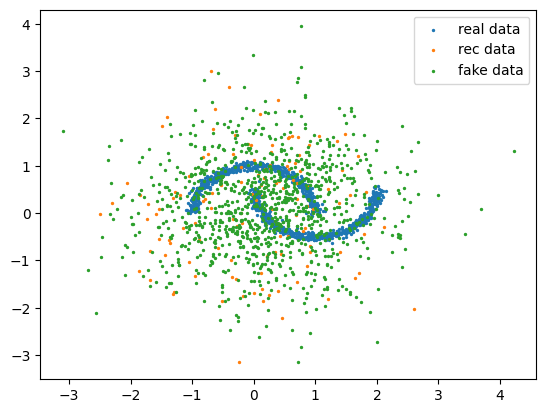

step 1000: KL: 5.768e+02, rec: -5.914e+01


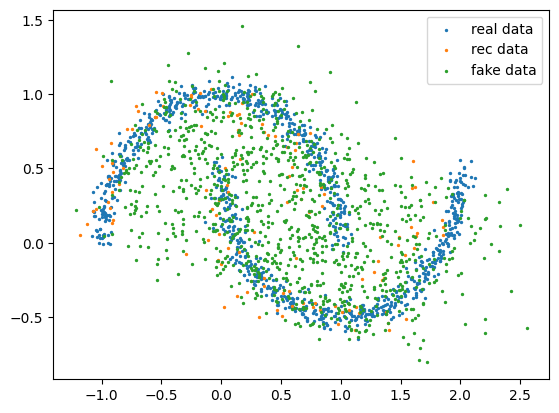

step 2000: KL: 6.946e+02, rec: -4.096e+02


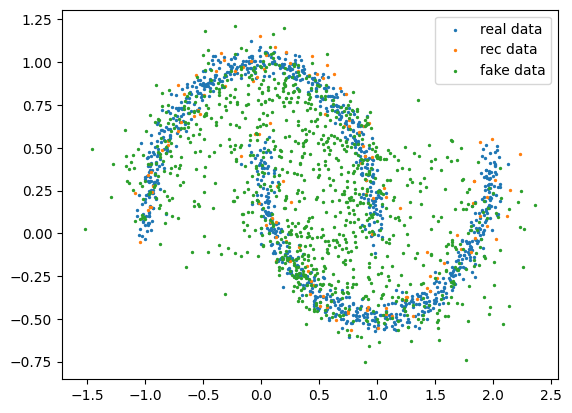

step 3000: KL: 7.277e+02, rec: -5.017e+02


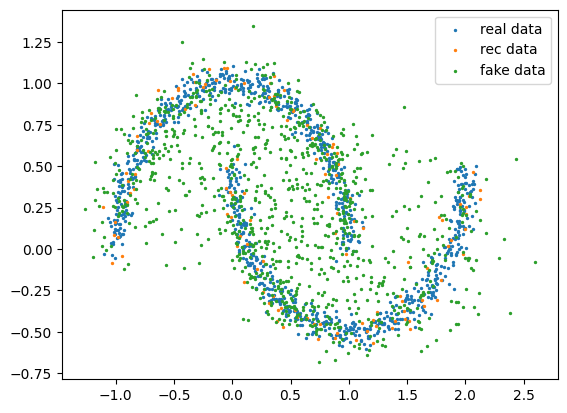

step 4000: KL: 7.624e+02, rec: -5.417e+02


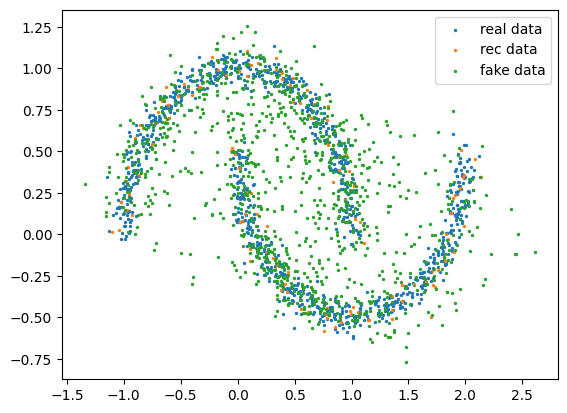

step 5000: KL: 8.010e+02, rec: -5.534e+02


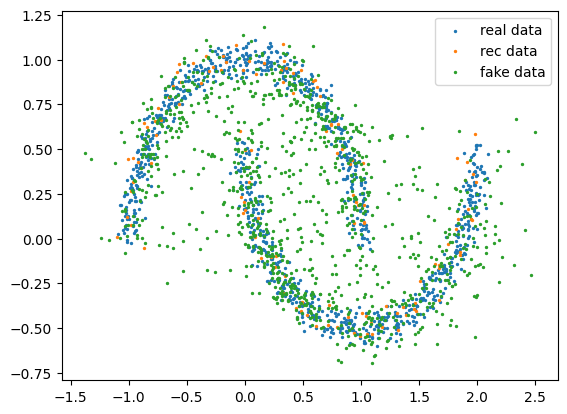

step 6000: KL: 8.267e+02, rec: -5.853e+02


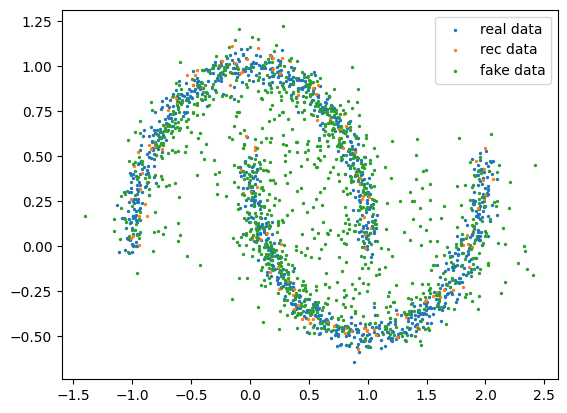

step 7000: KL: 8.316e+02, rec: -6.084e+02


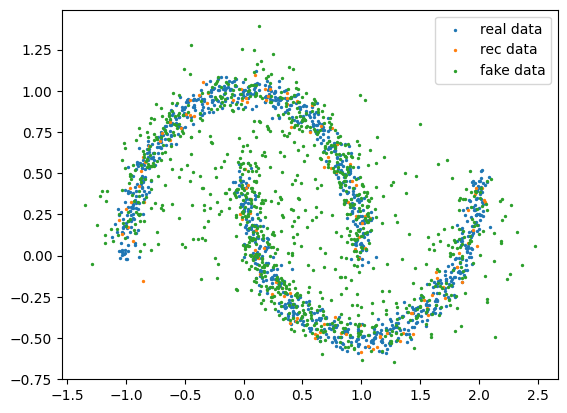

step 8000: KL: 8.793e+02, rec: -4.919e+02


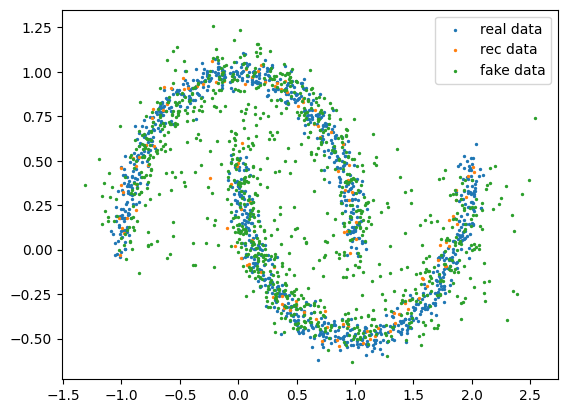

step 9000: KL: 8.828e+02, rec: -6.276e+02


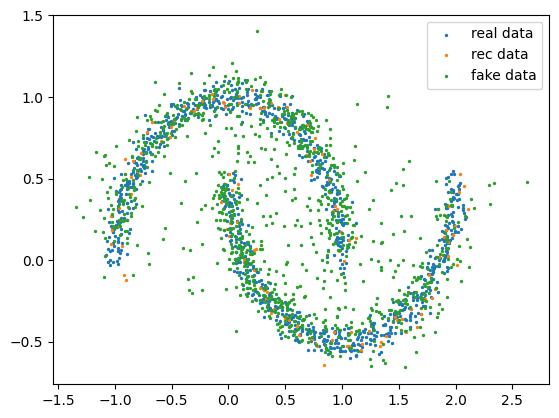

step 10000: KL: 8.614e+02, rec: -6.421e+02


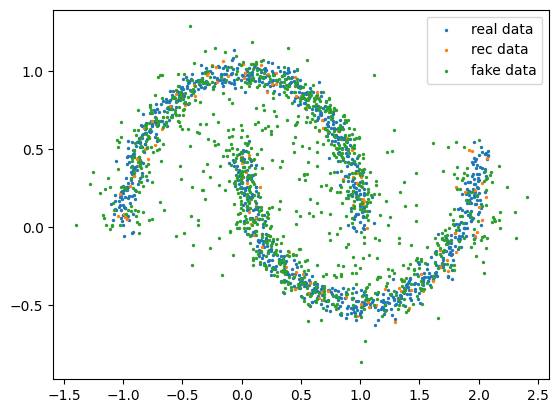

step 11000: KL: 8.884e+02, rec: -2.422e+02


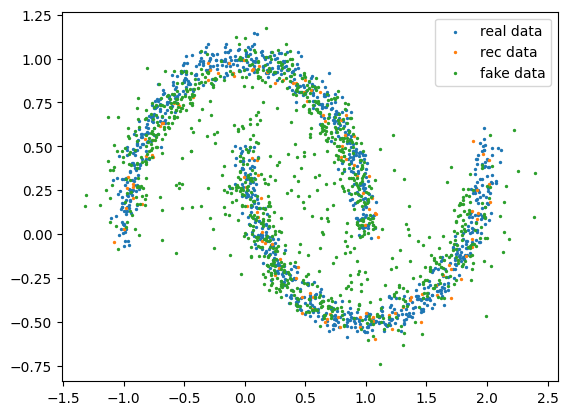

step 12000: KL: 8.967e+02, rec: -6.651e+02


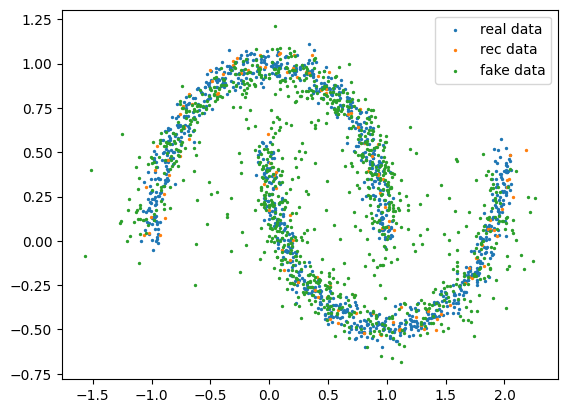

step 13000: KL: 9.036e+02, rec: -3.553e+02


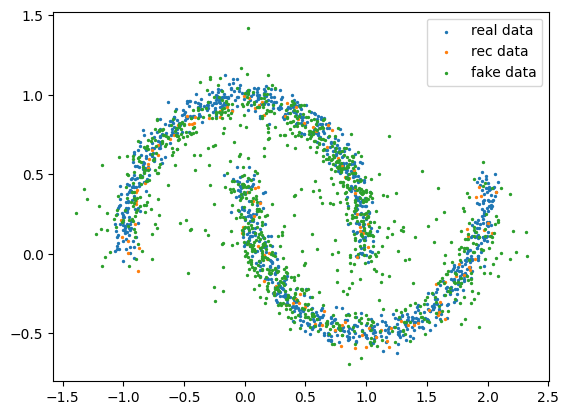

step 14000: KL: 9.113e+02, rec: -6.404e+02


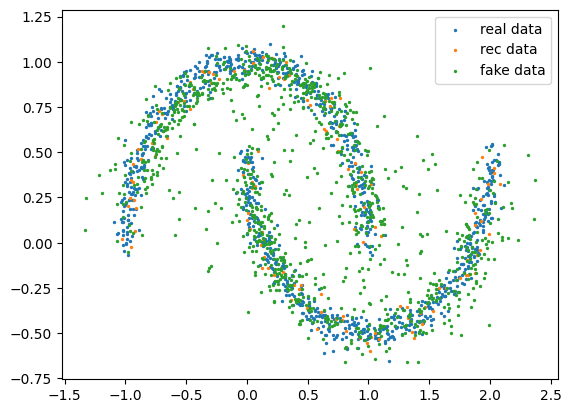

step 15000: KL: 9.118e+02, rec: -5.984e+02


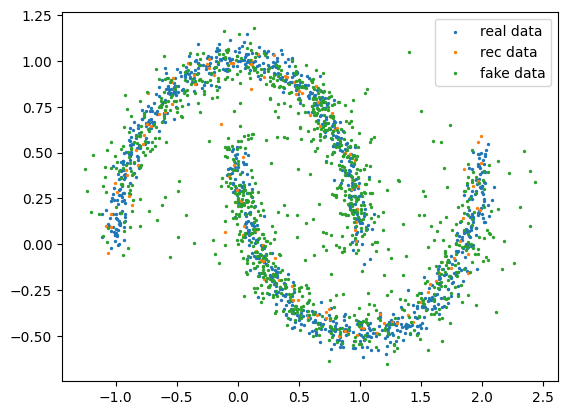

step 16000: KL: 9.229e+02, rec: -6.834e+02


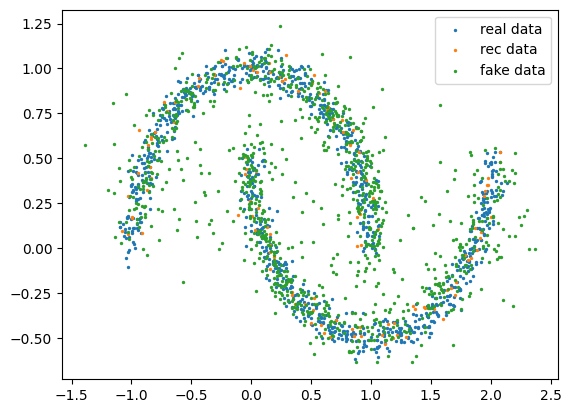

step 17000: KL: 9.190e+02, rec: -6.139e+02


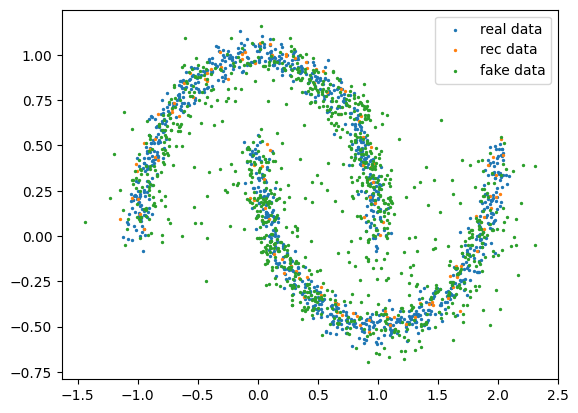

step 18000: KL: 9.251e+02, rec: -7.422e+02


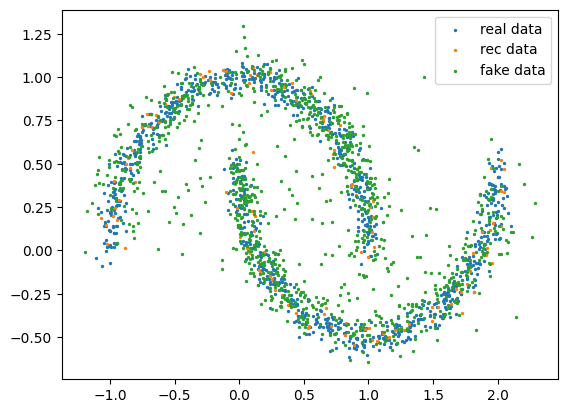

step 19000: KL: 9.335e+02, rec: -6.594e+02


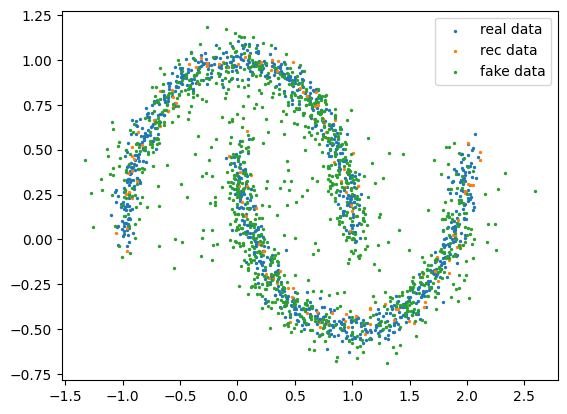

step 20000: KL: 9.456e+02, rec: -7.079e+02


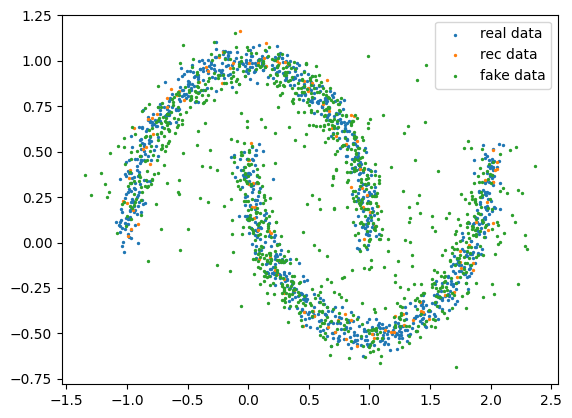

step 21000: KL: 9.544e+02, rec: -6.560e+02


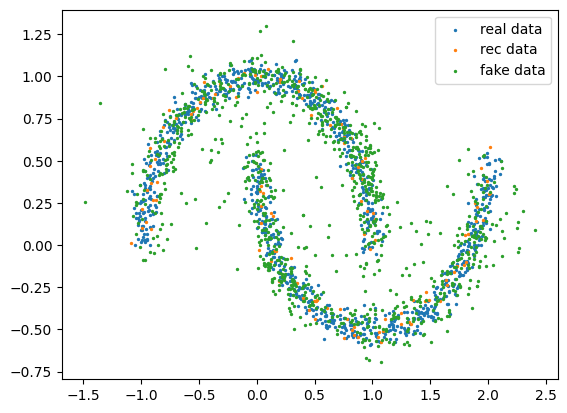

step 22000: KL: 9.467e+02, rec: -6.152e+02


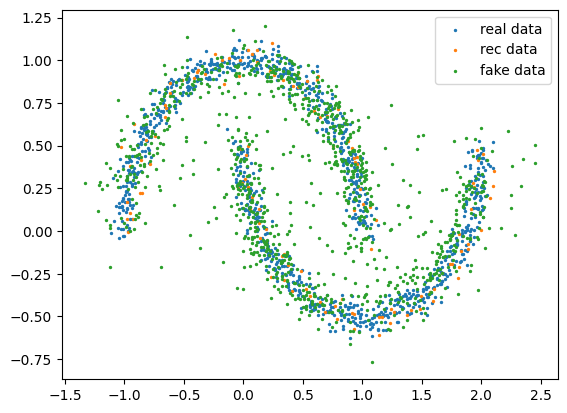

step 23000: KL: 9.519e+02, rec: -4.986e+02


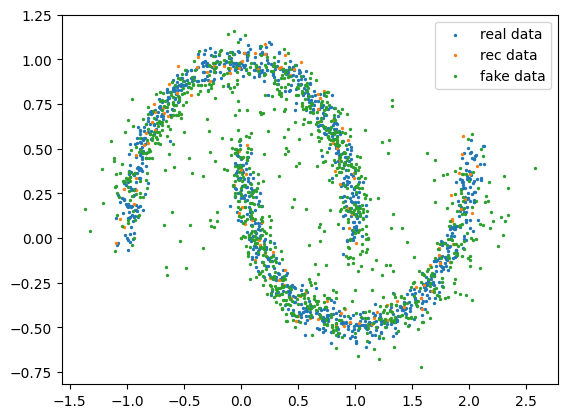

step 24000: KL: 9.617e+02, rec: -7.391e+02


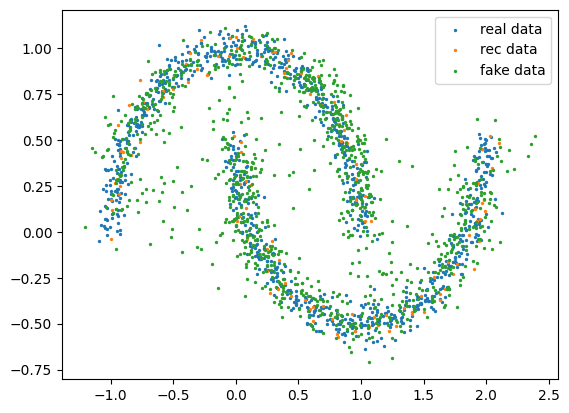

step 25000: KL: 9.651e+02, rec: -7.645e+02


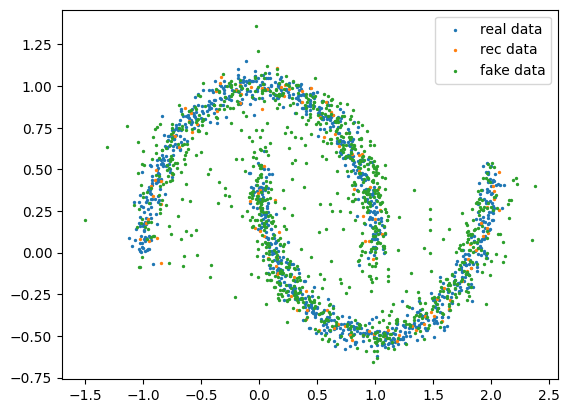

step 26000: KL: 9.748e+02, rec: -6.123e+02


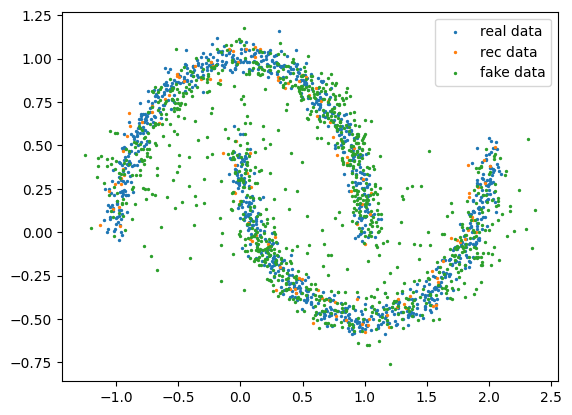

step 27000: KL: 9.633e+02, rec: -6.960e+02


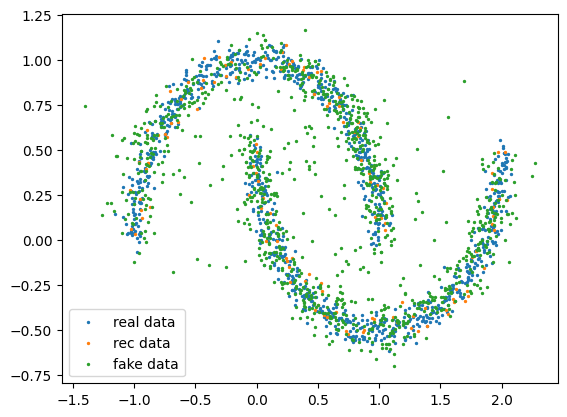

step 28000: KL: 9.840e+02, rec: -7.349e+02


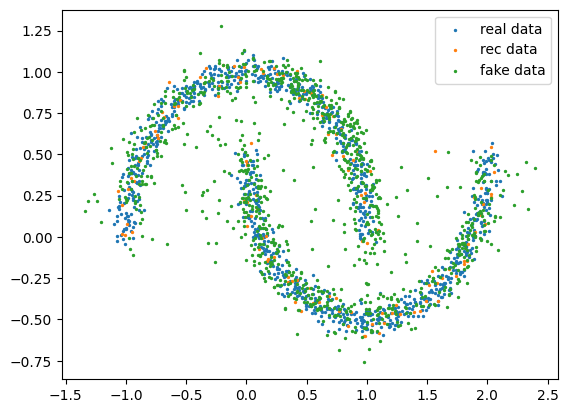

step 29000: KL: 9.744e+02, rec: -7.684e+02


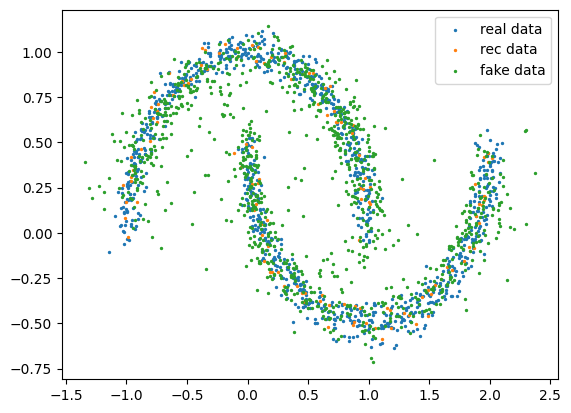

step 30000: KL: 9.751e+02, rec: -7.922e+02


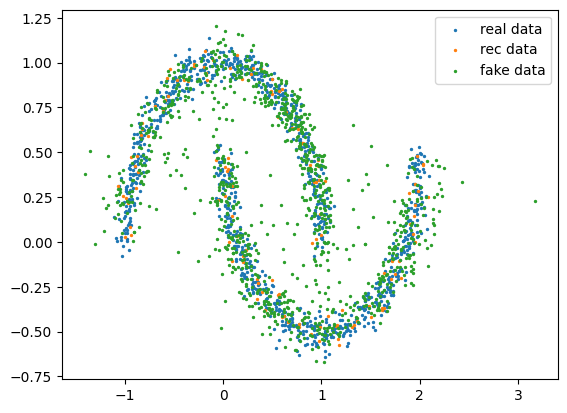

step 31000: KL: 1.001e+03, rec: -6.413e+02


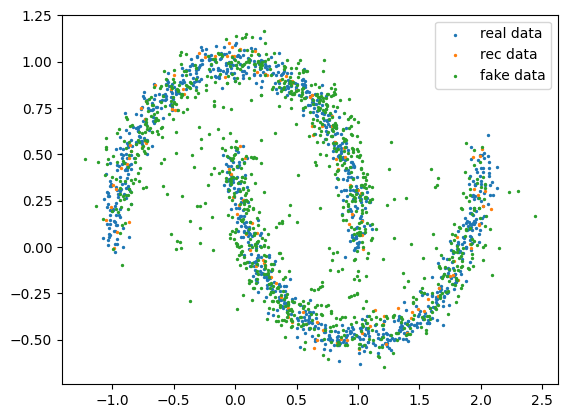

step 32000: KL: 9.802e+02, rec: -7.769e+02


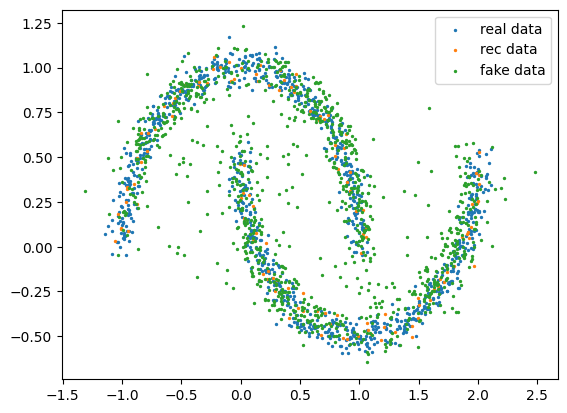

step 33000: KL: 9.918e+02, rec: -7.988e+02


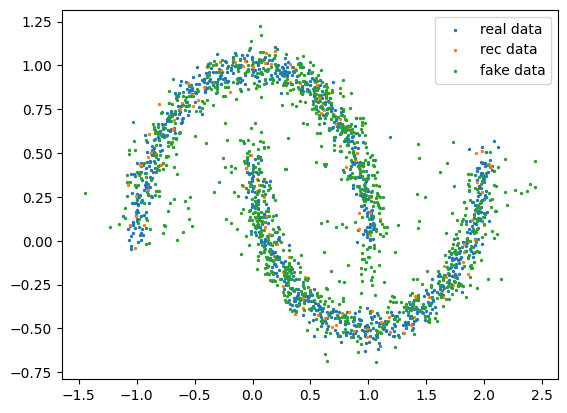

step 34000: KL: 9.855e+02, rec: -7.768e+02


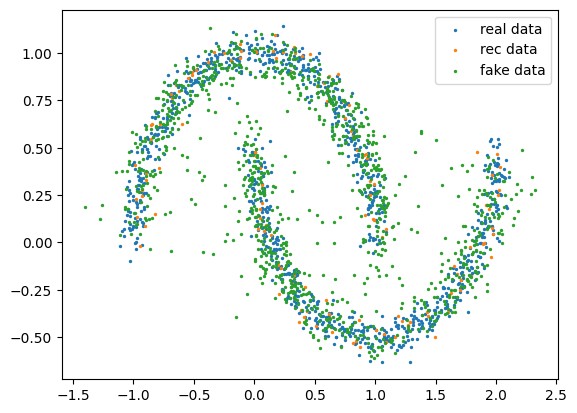

step 35000: KL: 1.001e+03, rec: -7.416e+02


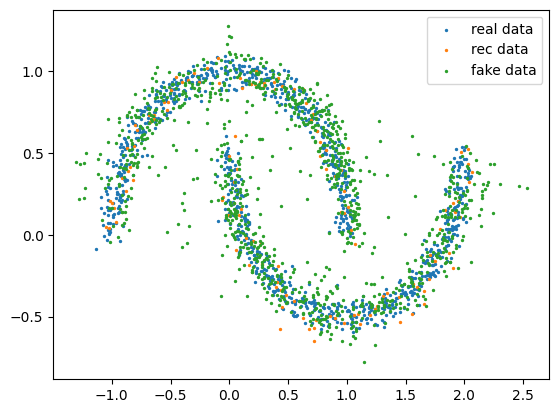

step 36000: KL: 9.988e+02, rec: -7.605e+02


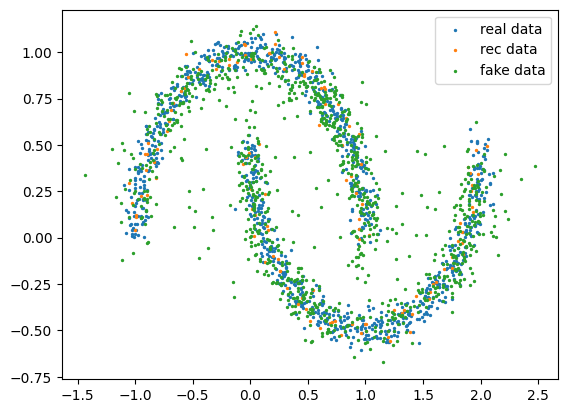

step 37000: KL: 1.012e+03, rec: -7.941e+02


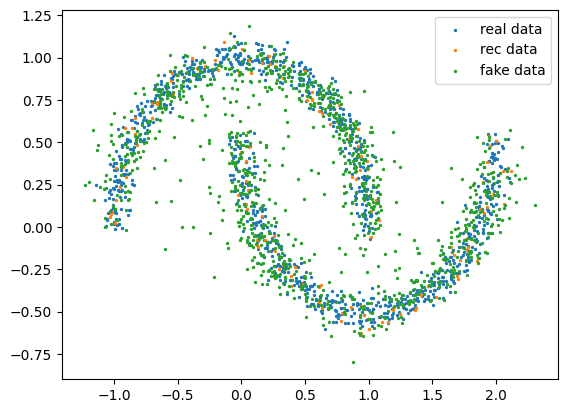

step 38000: KL: 1.010e+03, rec: -5.756e+02


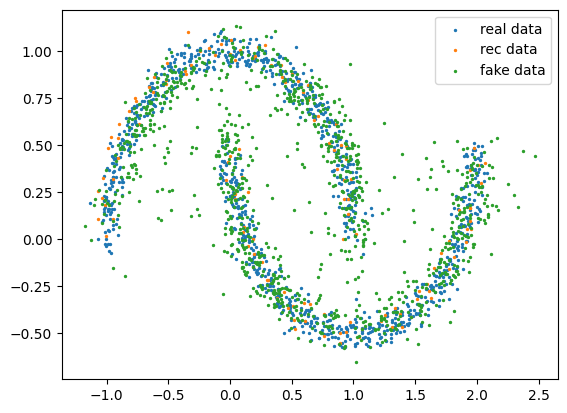

step 39000: KL: 1.007e+03, rec: -7.388e+02


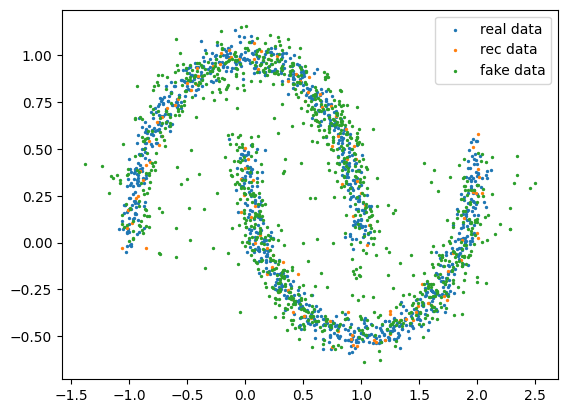

step 40000: KL: 1.013e+03, rec: -7.561e+02


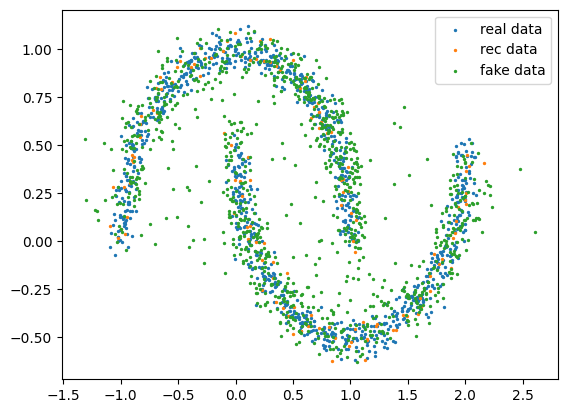

In [ ]:
# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))
decoder = Decoder()
optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()

    x = generate_batch(BATCHLEN)

    enc_mu, enc_logvar = encoder(x)
    #
    # COMPUTE THE KL PART OF THE LOSS HERE  loss_kl = torch.mean(-0.5*torch.sum(1+ enc_logvar - enc_mu.pow(2) - torch.exp(enc_logvar),dim=1),dim=0)
    #
    loss_kl = 0.5 * torch.sum(- enc_logvar -1  +torch.exp(enc_logvar) + enc_mu.pow(2))
    #
    # SAMPLE z FROM q(z|x) HERE
    #
    enc_sig = torch.exp(0.5*enc_logvar)
    z = enc_mu + enc_sig * torch.randn_like(enc_mu)

    dec_mu, dec_logvar = decoder(z)
    #
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    #
    loss_rec = 0.5 * torch.sum(dec_logvar + np.log(2 * np.pi) + (x - dec_mu).pow(2) * torch.exp(-dec_logvar) )

    (0.3*loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

To get this result, we need to use a deep neural network enough complex to solve our task. For the encoder and the decoder, I add an MLP at the entrance with 3 hidden layers and 256 units each.
After 10000 steps the model converge.

### Insipired by https://openreview.net/pdf?id=Sy2fzU9gl Beta-VAE, we decide to penalise the KL loss

**Q12: Try hardcoding $\sigma_\theta(z)$ to some small value (like 1E-4) rather than allowing the decoder to learn it. What does it change?**

In [ ]:
# Choose a value for the latent dimension
LATENT_N = 10

class Encoder(nn.Module):
    def __init__(self, number_layers=6, hidden_dim=256):
        super().__init__()
        self.number_layers = number_layers
        self.hidden_dim = hidden_dim
        self.encoder_layers = [nn.Linear(2, self.hidden_dim), nn.ReLU()]

        for i in range(1,self.number_layers) :
          self.encoder_layers.append(nn.Linear(self.hidden_dim, self.hidden_dim))
          self.encoder_layers.append(nn.ReLU())

        self.fc = nn.Sequential(*self.encoder_layers)
        self.fc_mu = nn.Linear(self.hidden_dim, LATENT_N)
        self.fc_logvar = nn.Linear(self.hidden_dim, LATENT_N)

    # encode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian q_\phi(z | x)
    def __call__(self, x):
        x = self.fc(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return (mu, logvar)

class Decoder(nn.Module):
    def __init__(self, number_layers=6, hidden_dim=256): #128
        super().__init__()
        self.number_layers = number_layers
        self.hidden_dim = hidden_dim
        self.decoder_layers = [nn.Linear(LATENT_N, self.hidden_dim), nn.ReLU()]

        for i in range(1,self.number_layers) :
          self.decoder_layers.append(nn.Linear(self.hidden_dim, self.hidden_dim))
          self.decoder_layers.append(nn.ReLU())

        self.fc = nn.Sequential(*self.decoder_layers)
        self.fc_mu = nn.Linear(self.hidden_dim, 2)

    # decode a datapoint. This should return a couple of tensors (mu, logvar) representing
    # the parameters of the Gaussian p_\theta(z | x)
    def __call__(self, z):
        z = self.fc(z)
        mu = self.fc_mu(z)
        logvar=  torch.ones_like(mu)*np.log(1e-8)
        return (mu, logvar)

    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, LATENT_N), 1.0)
        (mu, logvar) = self.__call__(z)
        return torch.normal(mu, torch.exp(0.5*logvar))

step 0: KL: 1.589e+00, rec: 8.764e+09


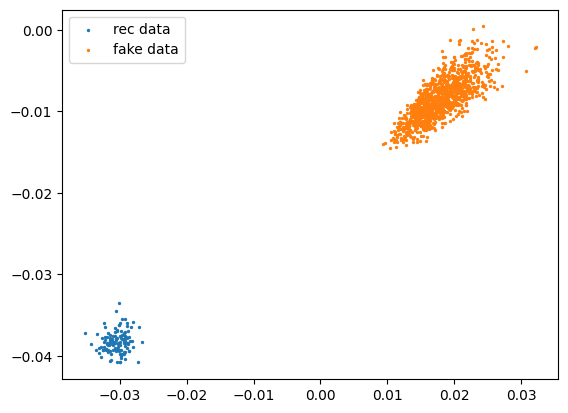

step 1000: KL: 1.744e+04, rec: 4.121e+07


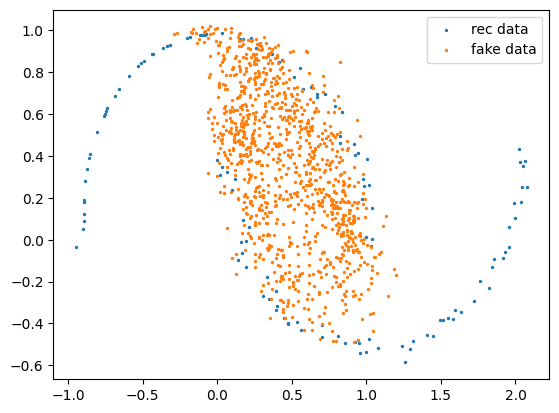

step 2000: KL: 2.977e+04, rec: 1.524e+07


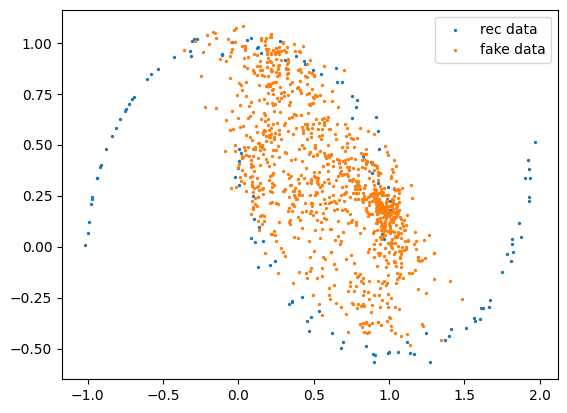

step 3000: KL: 2.837e+04, rec: 2.860e+07


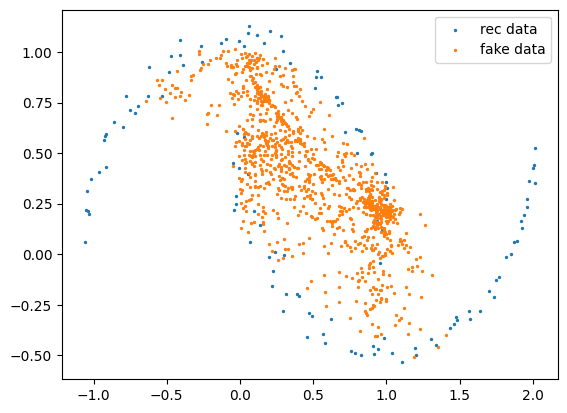

step 4000: KL: 3.815e+04, rec: 6.035e+06


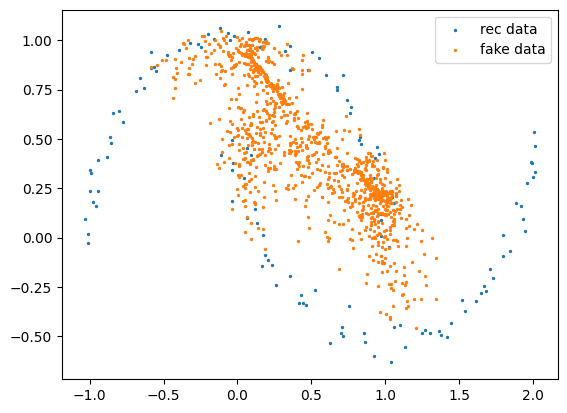

step 5000: KL: 4.096e+04, rec: 2.137e+06


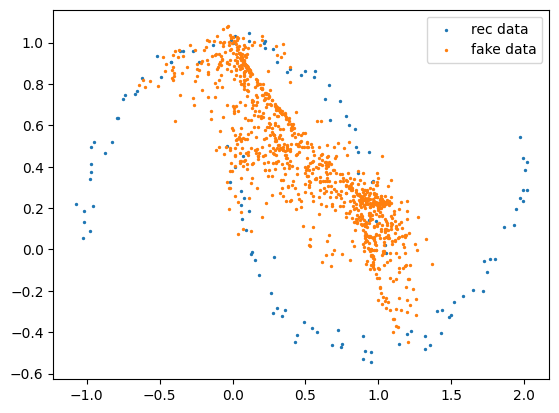

step 6000: KL: 4.931e+04, rec: 5.650e+06


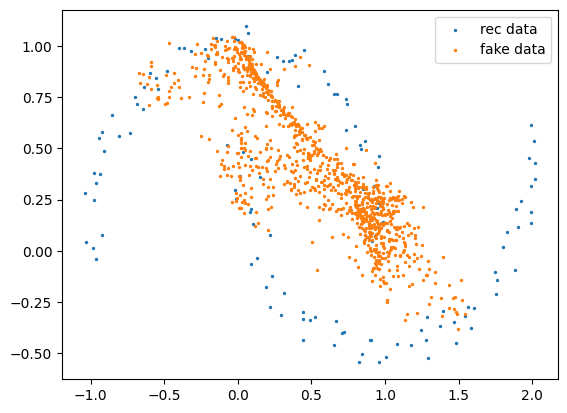

step 7000: KL: 4.685e+04, rec: 3.182e+06


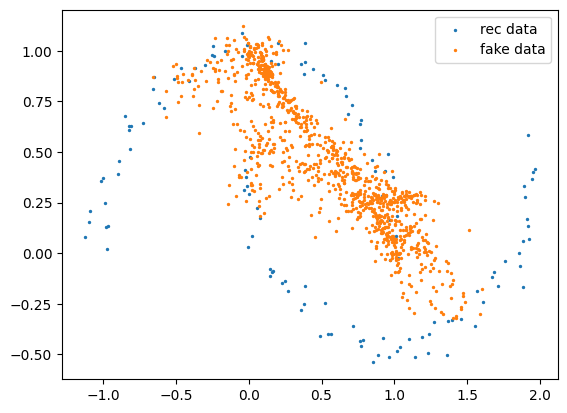

step 8000: KL: 5.454e+04, rec: 1.253e+07


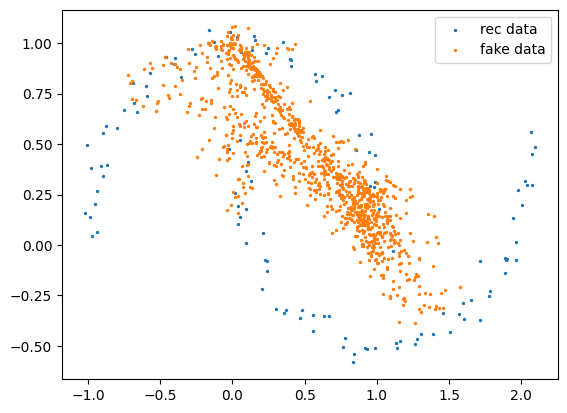

step 9000: KL: 5.219e+04, rec: 1.042e+06


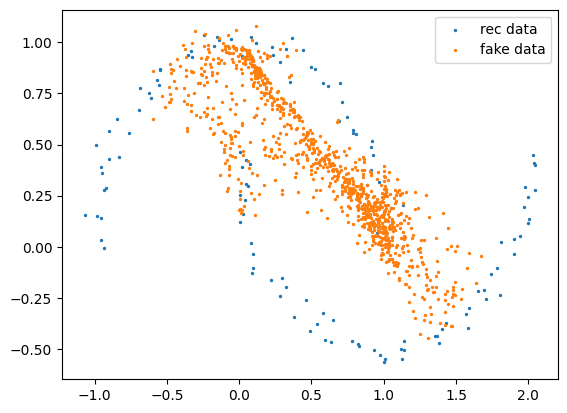

step 10000: KL: 5.921e+04, rec: 7.226e+06


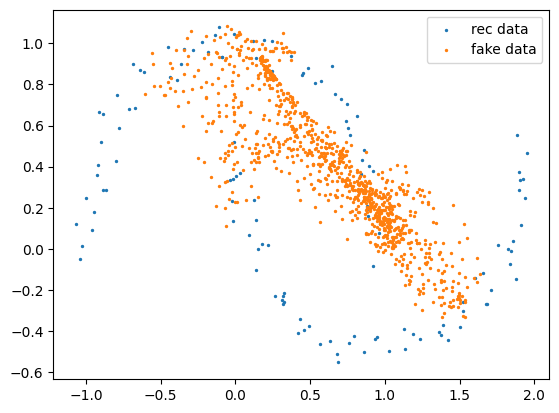

step 11000: KL: 5.192e+04, rec: 2.110e+06


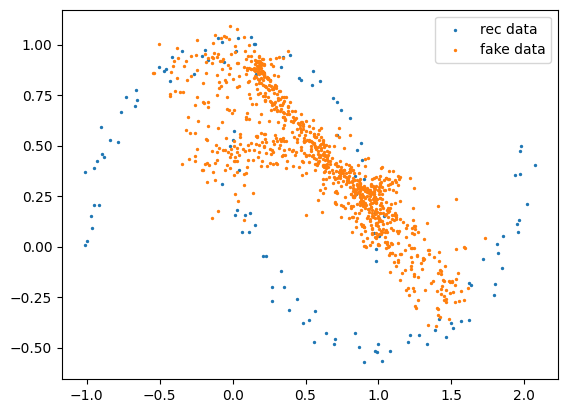

step 12000: KL: 6.103e+04, rec: 7.336e+06


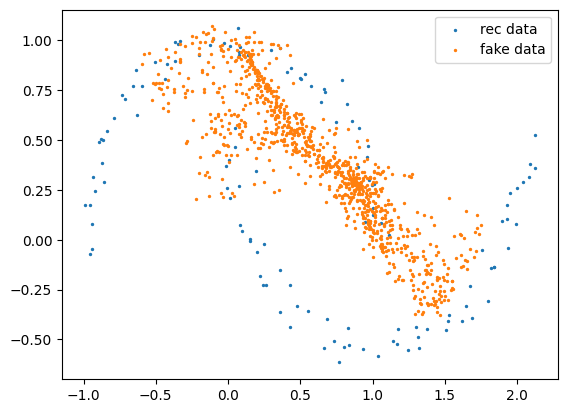

step 13000: KL: 5.208e+04, rec: 1.199e+06


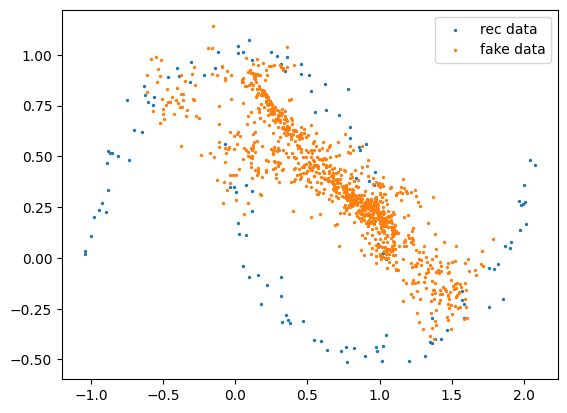

step 14000: KL: 4.918e+04, rec: 5.965e+06


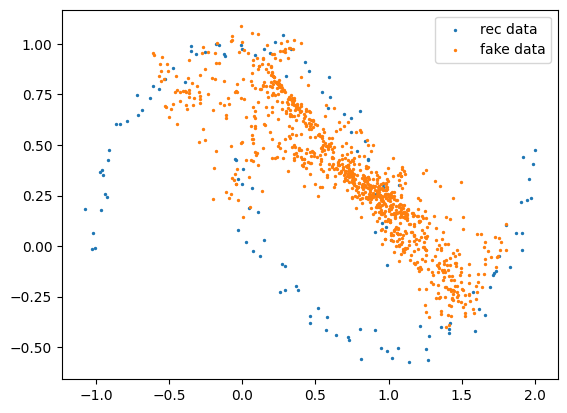

step 15000: KL: 4.715e+04, rec: 1.355e+06


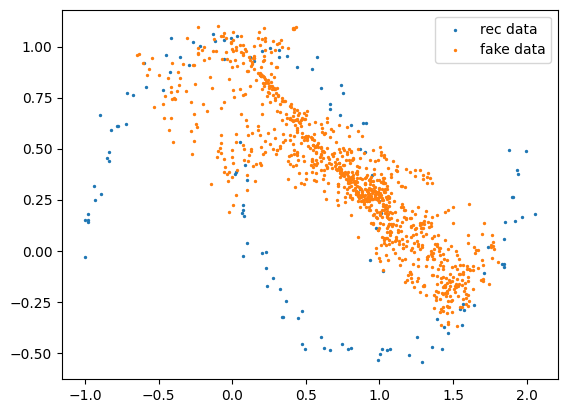

step 16000: KL: 5.470e+04, rec: 3.173e+06


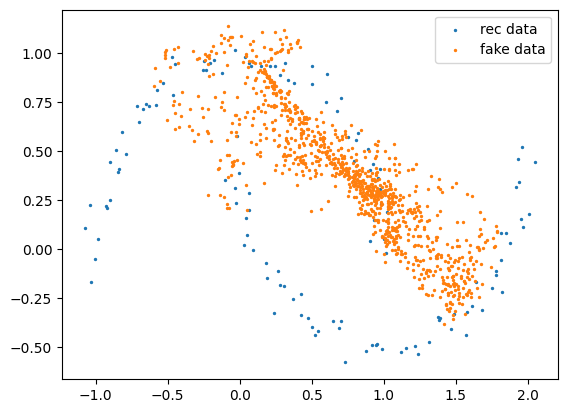

step 17000: KL: 4.902e+04, rec: 3.453e+06


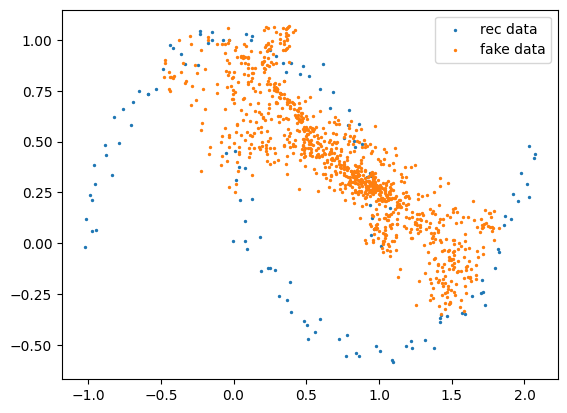

step 18000: KL: 4.000e+04, rec: 1.023e+06


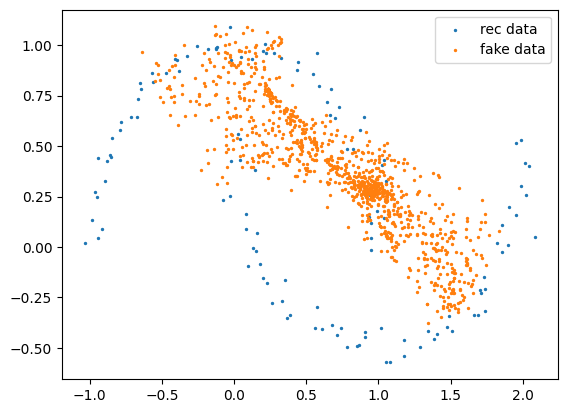

step 19000: KL: 4.334e+04, rec: 5.098e+05


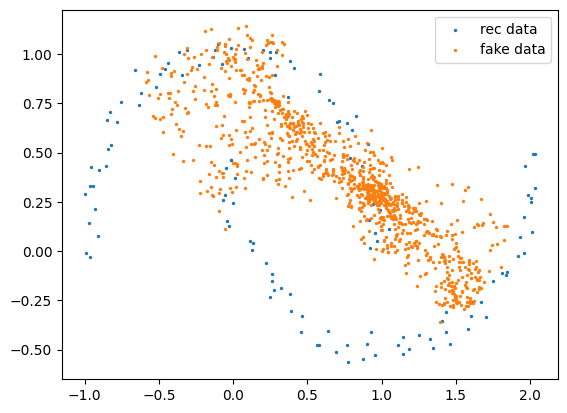

step 20000: KL: 3.910e+04, rec: 3.279e+06


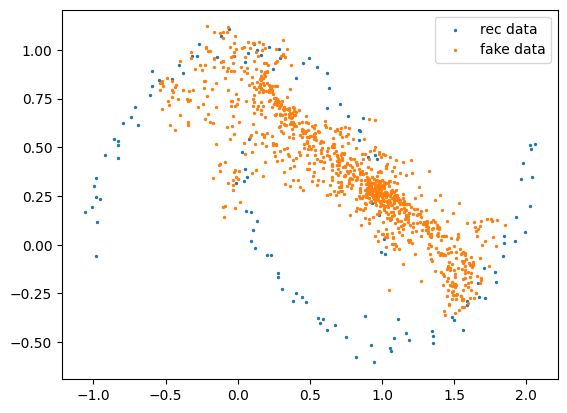

step 21000: KL: 3.808e+04, rec: 2.063e+06


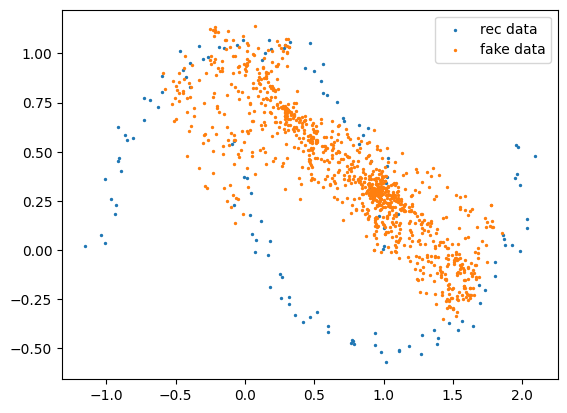

step 22000: KL: 4.596e+04, rec: 2.979e+06


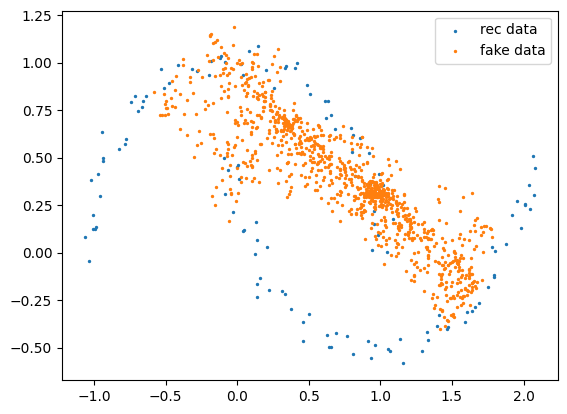

step 23000: KL: 4.284e+04, rec: 9.632e+05


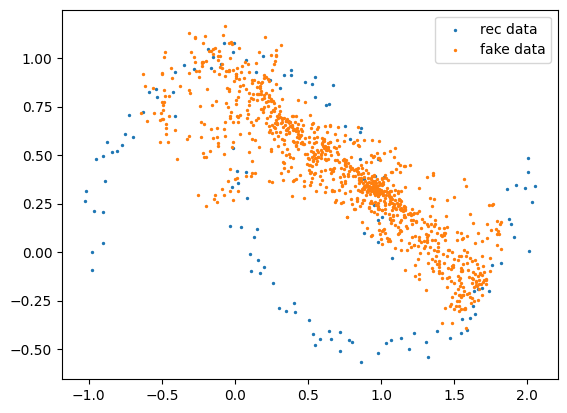

step 24000: KL: 4.163e+04, rec: 1.377e+06


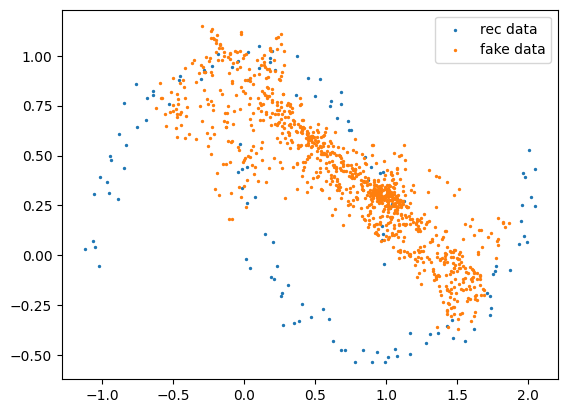

step 25000: KL: 4.215e+04, rec: 2.982e+06


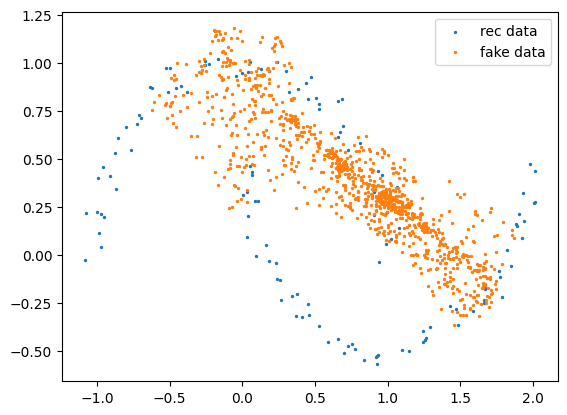

step 26000: KL: 3.561e+04, rec: 2.932e+05


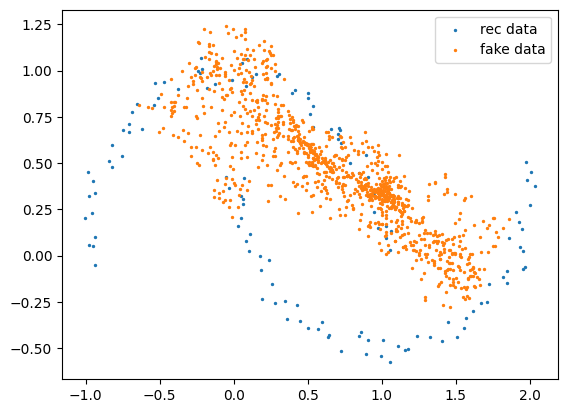

step 27000: KL: 5.566e+09, rec: 1.274e+09


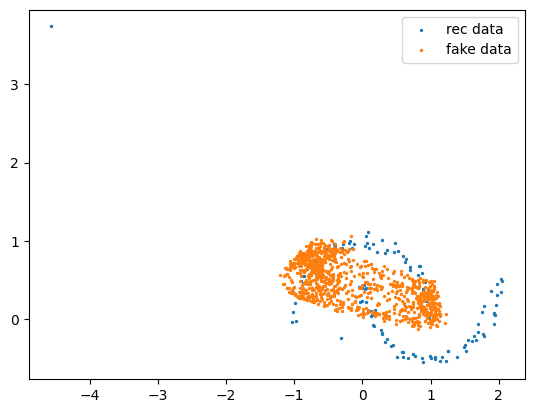

step 28000: KL: 5.845e+04, rec: 3.905e+05


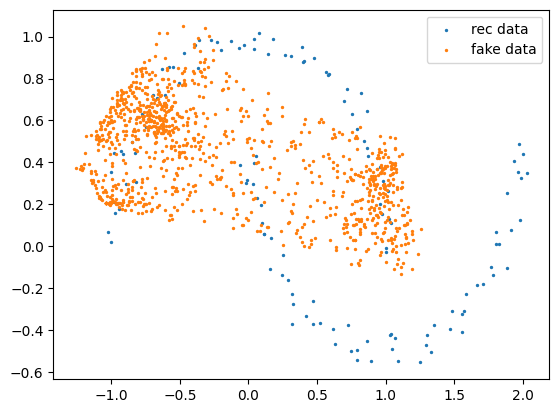

step 29000: KL: 5.844e+04, rec: 8.722e+05


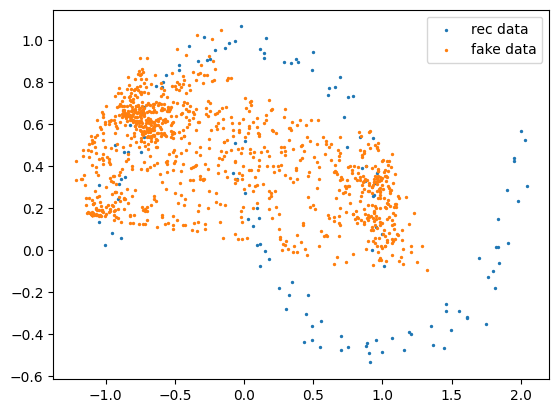

step 30000: KL: 6.035e+04, rec: 5.950e+05


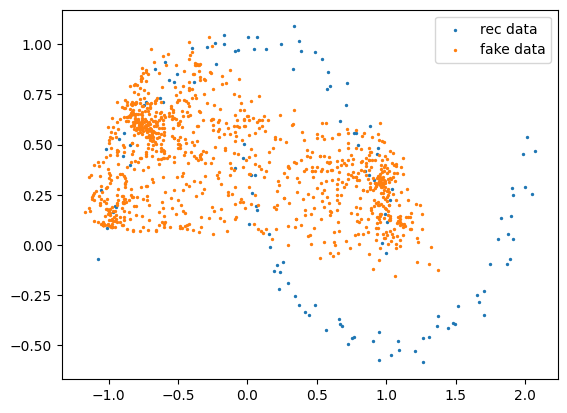

step 31000: KL: 5.248e+04, rec: 5.449e+05


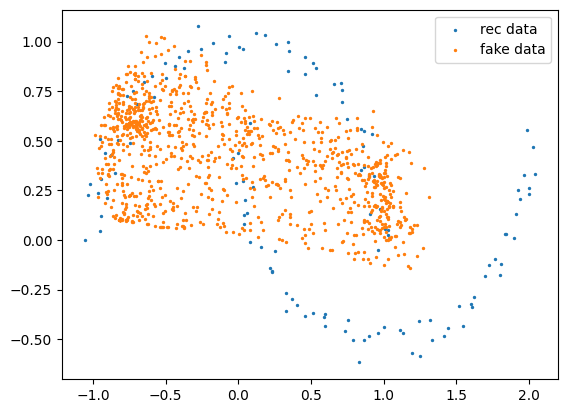

step 32000: KL: 5.639e+04, rec: 7.934e+05


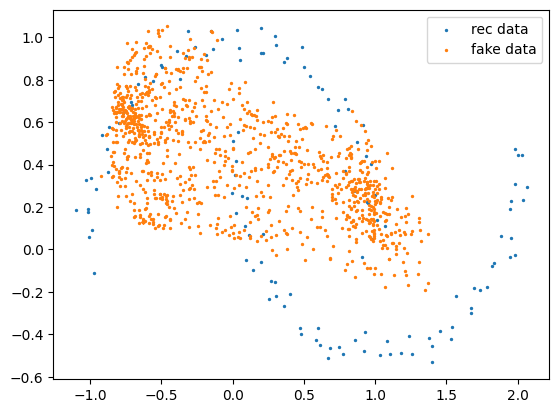

step 33000: KL: 4.744e+04, rec: 2.955e+05


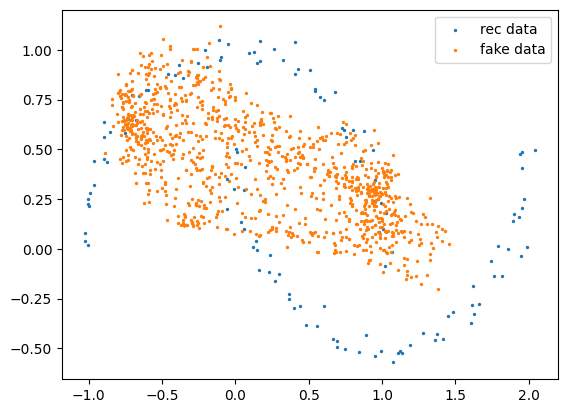

step 34000: KL: 5.110e+04, rec: 7.902e+05


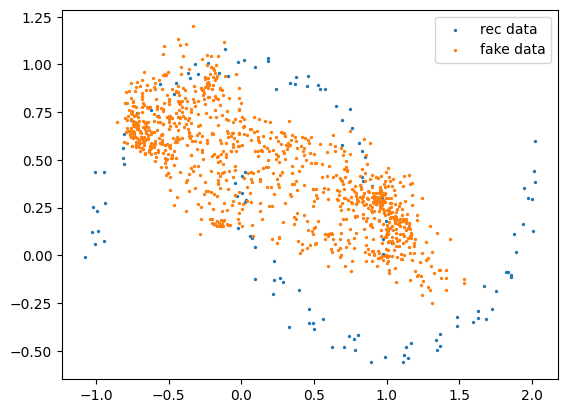

step 35000: KL: 4.556e+04, rec: 5.135e+05


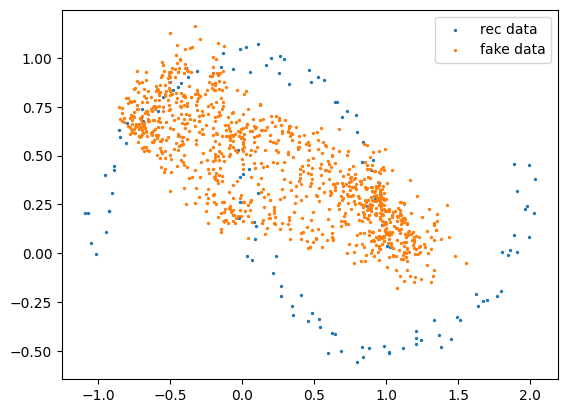

step 36000: KL: 4.532e+04, rec: 2.187e+05


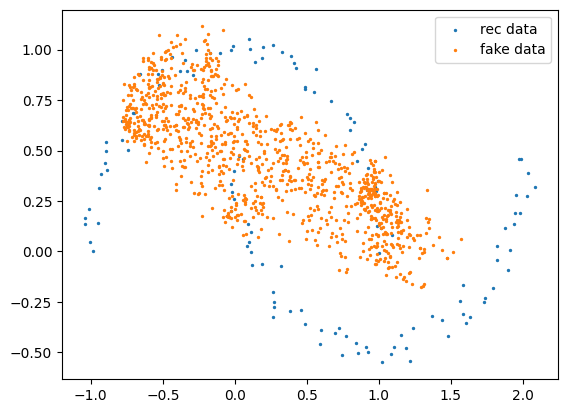

step 37000: KL: 4.506e+04, rec: 6.944e+05


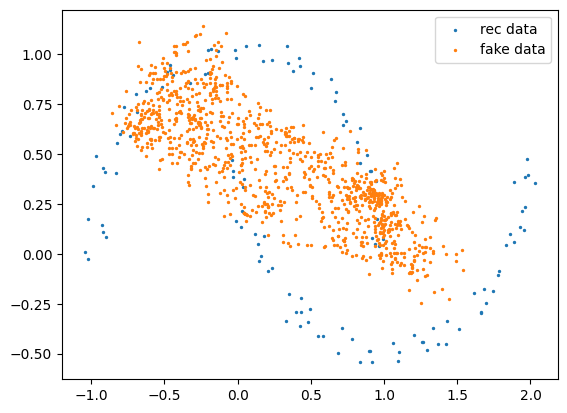

step 38000: KL: 3.698e+04, rec: 4.252e+05


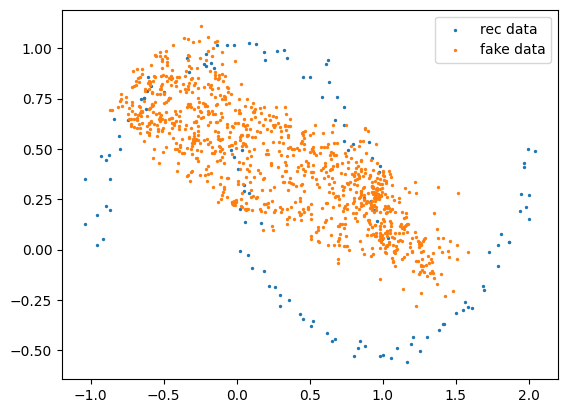

step 39000: KL: 4.525e+04, rec: 3.901e+05


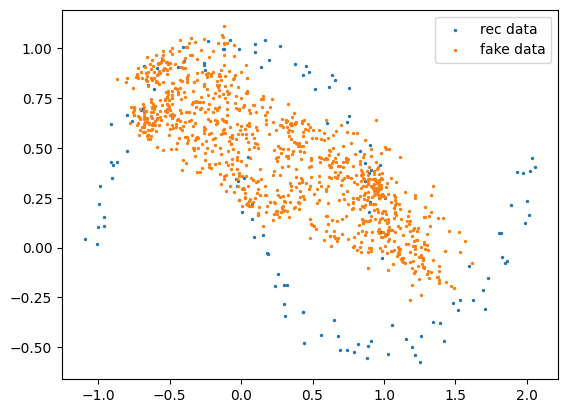

step 40000: KL: 4.108e+04, rec: 3.922e+05


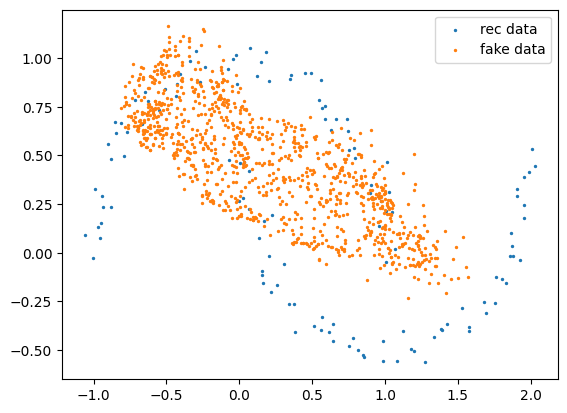

In [ ]:
# Total number of training iterations for the VAE
N_ITER = 40001
# Batch size to use
BATCHLEN = 128

encoder = Encoder()
optim_enc = torch.optim.Adam(encoder.parameters(), lr=0.001, betas=(0.5,0.9))

decoder = Decoder()

optim_dec = torch.optim.Adam(decoder.parameters(), lr=0.001, betas=(0.5,0.9))

for i in range(N_ITER):
    encoder.zero_grad()
    decoder.zero_grad()

    x = generate_batch(BATCHLEN)

    enc_mu, enc_logvar = encoder(x)
    #
    # COMPUTE THE KL PART OF THE LOSS HERE
    #
    loss_kl = 0.5 *  torch.sum(- enc_logvar -1  +torch.exp(enc_logvar) + enc_mu.pow(2))
    #
    # SAMPLE z FROM q(z|x) HERE
    #
    enc_sig = torch.exp(0.5*enc_logvar)
    z = enc_mu + enc_sig * torch.randn((BATCHLEN,LATENT_N))

    dec_mu, dec_logvar = decoder(z)
    #
    # COMPUTE THE RECONSTRUCTION PART OF THE LOSS HERE
    #
    loss_rec = 0.5 *  torch.sum(dec_logvar + np.log(2 * np.pi) + (x - dec_mu).pow(2) * torch.exp(-dec_logvar) )


    (0.3*loss_kl + loss_rec).backward()
    optim_enc.step()
    optim_dec.step()
    if i%1000 == 0:
        print('step {}: KL: {:.3e}, rec: {:.3e}'.format(i, float(loss_kl), float(loss_rec)))
        # plot the result
        real_batch = generate_batch(1024)
        rec_batch = torch.normal(dec_mu, torch.exp(0.5*dec_logvar)).detach()
        fake_batch = decoder.generate(1024).detach()
        # plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
        plt.scatter(rec_batch[:,0], rec_batch[:,1], s=2.0, label='rec data')
        plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
        plt.legend()
        plt.show()

When we fix the decodeur variance, the decodeur will only has to learn the mean, this could be a more complex task as we remove a degree of liberty that why we have to use a more complex model to get some relevant results. More over, by setting decodeur variance to a low value, we reduce the variance of the output of the model and that could lead to a kind of overfitting as we see during the training. The reconstruction data fit directly the input distribution after only 10000 steps while the fake data takes a more times to fit a bit the input distribution.

**Q13: How do the power of encoder and decoder affect the overall training of the VAE?**

Firstly, the encoder plays an essential role in determining the efficiency of the VAE latent space representation. By encoding input data in a lower-dimensional latent space, the encoder essentially defines the compact representation of the data. A well-designed encoder can capture the underlying structure and essential features of the data, facilitating better reconstruction and generation. Consequently, the accuracy and fidelity of reconstructed data is highly dependent on the quality of the latent space created by the encoder. Consequently, the performance of the encoder significantly influences the overall accuracy and quality of the VAE results.

On the other hand, the role of the decoder is to reconstruct the data from the latent space representation generated by the encoder.  While the encoder shapes the latent space, the decoder plays a crucial role in transforming the encoded information back into the original data space. A competent decoder ensures that the reconstructed data corresponds closely to the original input, indicating a successful learning process. In essence, the decoder serves as a feedback mechanism, providing indications of the quality of the latent space representation.


---
### Normalizing flows

Another approach to generative modelling is given by Normalizing flows. The idea is to learn a mapping $f$ from the data distribution $p_D$ (defined over a space $\mathcal{X}$) to a known distribution (typically, a normal distribution) from which we know how to sample. Two key points are to be noted:
1. The mapping needs to be bijective (i.e., the network needs to be invertible).
2. The exact likelihood of a data point should be easily computable.

To tackle point 2, let us introduce some notations.
Let us denote by $p_\mathcal{N} = \mathcal{N}(0,1)$ the normal distribution from which we sample $z$. We obtain points $x$ by computing $x = f^{-1}(z)$, and we hope that the distribution of points obtained this way will match more or less the dataset distribution $p_D$ of real examples.
We denote by $p_G$ this obtained distribution, that is, the image of $p_\mathcal{N}$ through $f^{-1}$: $p_G$ is a probability distribution defined on $\mathcal{X}$, and our goal will be to optimize the mapping $f$ so that $p_G$ is close to $p_D$. If you are not familiar with images of distributions, the definition is here: https://en.wikipedia.org/wiki/Pushforward_measure ; it can be defined as the measure that satisfies this change of variables: $\int_{z\sim p_\mathcal{N}} g(f^{-1}(z)) dz = \int_{x\sim p_{G}} g(x) dx$ for all functions $g$. Another notation for this is $\int_{z} g(f^{-1}(z)) \;dp_\mathcal{N}(z) = \int_{x} g(x) \;dp_{G}(x)$.
We will build on the following identity:
$$
\log(p_X(x))=\log(p_Z(z))+\log \det J_f
$$
where $J_f = \frac{df(x)}{dx}$ is the Jacobian matrix of the function $f$.

**Q14: Justify the above equality**

> (Write your answer here)

Let us consider, as an optimization criterion, the Kullback-Leibler divergence $KL(p_D||p_G)$.

**Q15: Express this loss as a (very simple) function of the quantity above.**

> (Write your answer here)

A challenging task is then to find a network, such that f is:
* invertible
* $\det J_f$ is tractable
* $f$ is general enough

A common architecture is the so called real-valued non-volume preserving (real-NVP), which is made of coupling layers.

The idea of coupling layers is to cut the input $x$ in two (let say keeping only the $d < D$ first dimensions on one hand and the $D-d$ other dimensions on the other hand, with $D$ the dimension of the input space $\mathcal{X}$). This gives inputs $x_{1:d}$ and $x_{d+1:D}$. Then the forward pass is defined as:
* $y_{1:d}=x_{1:d}$
* $y_{d+1:D}=x_{d+1:D}\odot \exp(s(x_{1:d})) + t(x_{1:d})$

where $s,t:\mathbb{R}^d\to\mathbb{R}^{D-d}$ and $\odot$ is the coefficient-wise multiplication of two vectors of the same size.

Those equations can be resumed in the following diagram:
![real NVP diagram](./realNVPforward.png)

**Q16: Show that the defined mapping is indeed invertible**

> (Write your answer here)

**Q17: Show that the determinant of the Jacobian of such a mapping is $\exp(\sum_j s(x_{1:d})_j)$**

> (Write your answer here)

**Q18: Fill the Coupling layer structure below by defining suitable functions sfun and tfun (using a final tanh in sfun is highly recommended) and the inverse pass**

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F


class CouplingLayer(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, mask):
        super().__init__()
        ### define here variables to use in f and s ###

        ###
        self.mask = mask #we use the mask variable to make the cut in input

    def sfun(self, x_m):
        return x_m

    def tfun(self, x_m):
        return x_m

    def forward(self, x):
        x_m = x * self.mask
        s_out = self.sfun(x_m) # multiplicative block
        t_out = self.tfun(x_m) # additive block
        y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
        log_det_jacobian = s_out.sum(dim=1)  # CRITICAL
        return y, log_det_jacobian

    def inverse(self, y):
        return y

In [ ]:
class RealNVP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, mask, n_layers=6):
        super().__init__()
        assert n_layers >= 2, "num of coupling layers should be greater or equal to 2"

        self.modules = []
        self.modules.append(CouplingLayer(input_size, output_size, hidden_dim, mask))
        for _ in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_size, output_size, hidden_size, mask))
        self.modules.append(CouplingLayer(input_size, output_size, hidden_size, 1 - mask))
        self.module_list = nn.ModuleList(self.modules)

    def forward(self, x):
        ldj_sum = 0  # sum of log determinant of jacobian
        for module in self.module_list:
            x, ldj = module(x)
            ldj_sum += ldj
        return x, ldj_sum

    def inverse(self, z):
        for module in reversed(self.module_list):
            z = module.inverse(z)
        return z

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch


def train(epoch, model, optimizer, prior_z, train_loader, log_interval=50):
    model.train()
    train_loss = 0
    for batch_idx, x_inputs in enumerate(train_loader):
        optimizer.zero_grad()
        z_outputs, log_det_j_sum = model.forward(x_inputs)  # train with the forward
        loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean()  # CRITICAL
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(x_inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), cur_loss / len(x_inputs)))

    average_train_loss = train_loss / len(train_loader.dataset)
    print(f"====> Epoch: {epoch} Average train loss: {average_train_loss:.4f}")


def test(epoch, model, prior_z, test_loader):
    model.eval()
    test_loss = 0
    x_all = np.array([[]]).reshape(0, 2)
    z_all = np.array([[]]).reshape(0, 2)
    with torch.no_grad():
        for batch_idx, x_inputs in enumerate(test_loader):
            z_outputs, log_det_j_sum = model.forward(x_inputs)
            cur_loss = -(prior_z.log_prob(z_outputs)+log_det_j_sum).mean().item()
            test_loss += cur_loss
            x_all = np.concatenate((x_all, x_inputs.numpy()))
            z_all = np.concatenate((z_all, z_outputs.numpy()))

        subfig_plot(1, x_all, -2, 3, -1, 1.5, "Input: x ~ p(x)", "b")
        subfig_plot(2, z_all, -3, 3, -3, 3, "Output: z = f(x)", "b")

        test_loss /= len(test_loader.dataset)
        print(f"====> Test loss: {test_loss:.4f}")


def sample(epoch, model, prior_z, save_plt_interval=5):
    model.eval()
    with torch.no_grad():
        z_inputs = prior_z.sample((1000,))
        x_outputs = model.inverse(z_inputs)  # generation with the inverse
        z_inputs = z_inputs.numpy()
        x_outputs = x_outputs.numpy()

        subfig_plot(3, z_inputs, -3, 3, -3, 3, "Input: z ~ p(z)", "r")
        subfig_plot(4, x_outputs, -2, 3, -1, 1.5, "Output: x = g(z) (g: inverse of f)", "r")

        if epoch % save_plt_interval == 0:
            if not os.path.exists("results"):
                os.makedirs("results")
            plt.savefig("results/"+"result_"+str(epoch)+".png")


def subfig_plot(location, data, x_start, x_end, y_start, y_end, title, color):
    if location == 1:
        plt.clf()
    plt.subplot(2, 2, location)
    plt.scatter(data[:, 0], data[:, 1], c=color, s=1)
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)
    plt.title(title)
    plt.pause(1e-2)

In [ ]:
# globals
BATCH_SIZE = 128
LOG_INTERVAL = 50
N_EPOCHS = 10
INPUT_SIZE = 2
OUTPUT_SIZE = 2
HIDDEN_SIZE = 256
SAVE_PLT_INTERVAL = 5
N_COUPLING_LAYERS = 8

In [ ]:
# data loading
train_data = datasets.make_moons(n_samples=50000, noise=.05)[0].astype(np.float32)
test_data = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loader_kwargs = {"num_workers": 1, "pin_memory": True} if device == "cuda" else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, **loader_kwargs)

In [ ]:
from torch import distributions # optim,
# model construction
mask = torch.from_numpy(np.array([0, 1]).astype(np.float32))
model = RealNVP(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, mask, N_COUPLING_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
prior_z = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

In [ ]:
from timeit import default_timer as timer
# run
start = timer()
for epoch in range(1, N_EPOCHS + 1):
    train(epoch, model, optimizer, prior_z, train_loader)
    test(epoch, model, prior_z, test_loader)
    sample(epoch, model, prior_z)
f"{timer() - start:.02f}s"

**Q19: Explain why Normalizing flows do not fit well when there are many clusters in data**

> (Write your answer here)

---
## Denoising Diffusion Model

Recently Diffusion Models received a lot of attention. __Diffusion Models Beat GANs on Image Synthesis__ *(Dhariwal,Nichol)* : [arXiv:2105.05233](https://arxiv.org/pdf/2105.05233.pdf) shows significant improvement on image generation with a model claimed to be easier to train than GANs.


It is the key of the image generating process behind Latent Diffusion models such as Dall.e, Imagen or StableDiffusion.

We are going to implement a model inspired by the paper
__Denoising Diffusion Probabilistic Models__  *(Ho et al.)*: [arXiv:2006.11239](https://arxiv.org/pdf/2006.11239.pdf)


 Denoising diffusion probabilistic model  introduce noise into data and gradually learn to reverse this process for generating new samples. It involves two Markov chains, one that forwards data to noise, and another that reverses this process by converting the noise back to data. The forward chain is usually designed to transform any data distribution into a simpler prior distribution, such as a standard Gaussian distribution, while the reverse Markov chain is parametrized by a neural network and learns to reverse this process. To generate new data points, we first sample a random vector from the prior distribution, then applies ancestral sampling through the reverse Markov chain.

 References:

- Survey on Diffusion Models : https://arxiv.org/pdf/2209.00796.pdf
- https://lilianweng.github.io/posts/2021-07-11-diffusion-models/
- https://blog.alexalemi.com/diffusion.html
- https://sander.ai/posts/



![Denoisingdiagram](./illustrationDenoising.png)

$q$ and $p_{\theta}$ being the respective kernels of the two chains.


#### Forward Pass ####

For our purpose we are going to use a Gaussian Noise. The forward Kernel will have the following shape :

$$q(x_t| x_{t-1}) = \mathcal{N}(x_t;\sqrt{1- \beta_t} x_{t-1},\beta_t I )$$

with $\mathcal{N}(x;\mu,\sigma I )$ a conditional gaussian :
$$ y \sim \mathcal{N}(x;\mu,\sigma I ) \equiv y|x \sim  \mathcal{N}(\mu,\sigma I )$$

**Q20: What does $\beta_t$ represent in the formula ?**

In the formula, $\beta_t$ represents the variance of the added gaussian noise at each forward step.

It is known as the "diffusion rate" and the whole sequence is called the variance schedule $\beta_1, \ldots, \beta_T$. In the forward pass we want to reach a normal distribution. Therefore, the extreme case would be to put $\beta_1=1$, but doing this we would lose all the information and applying the reverse process would be impossible. That is why it is necessary to choose well the variance schedule in order to reach a distribution close to the normal one while keeping some information of the data.

In our example the sequence $\beta_t$ will be chosen linearly wrt $t$.

We introduce $\alpha_t := 1-\beta_t$ and $\overline{\alpha_t} = \prod_{s=1}^{t} \alpha_s$ we can sample forward directly at timestep $t$ from the original image :
$$q(\mathbf{x}_{1:T}|\mathbf{x}_0) = \prod_{t=1}^{T}q(\mathbf{x}_t|\mathbf{x}_{t-1})$$
$$ q(\mathbf{x}_t| \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t;\sqrt{\overline{\alpha_t}} \mathbf{x}_0, (1-\overline{\alpha_t})I)$$

i.e.
\begin{align}
\boldsymbol{x}_t = \sqrt{\bar{\alpha}_t} \boldsymbol{x}_0 + \sqrt{1 - \bar{\alpha}_t} \boldsymbol{\epsilon} \;\;\; \text{where} \; \boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})
\end{align}

we will then fix $$\sigma_t = \sqrt{1 - \bar{\alpha}_t}$$

**Q22:  Implement the forward pass using $\overline{\alpha_t}$ (Hint : you may need to precalculate the $\overline{\alpha_t}$ from $\beta_t$)**

In [7]:
def bcast_right(x: torch.Tensor, ndim: int) -> torch.Tensor:
    """Util function for broadcasting to the right."""
    if x.ndim > ndim:
        raise ValueError(f'Cannot broadcast a value with {x.ndim} dims to {ndim} dims.')
    elif x.ndim < ndim:
        difference = ndim - x.ndim
        return x.view(x.shape + (1,) * difference)
    else:
        return x


In [8]:
class DiscreteDDPMProcess:
    """A Gaussian diffusion process: q(xt|x0) = N(sqrt_alpha_bar(t)*x0, sigma(t)^2 * I),
    which implies the following transition from x0 to xt:

    xt = sqrt_alpha_bar(t) x0 + sigma(t) eps, eps ~ N(0, I).

    Diffusion processes differ in how they specify sqrt_alpha_bar(t) and/or sigma(t).
    Here we follow the DDPM paper.

    """
    def __init__(
        self,
        num_diffusion_timesteps: int = 1000,
        beta_start: float = 0.0001,
        beta_end: float = 0.02,
    ):
        self._num_diffusion_timesteps = num_diffusion_timesteps
        self._beta_start = beta_start
        self._beta_end = beta_end
        self._betas = np.linspace(self._beta_start, self._beta_end, self._num_diffusion_timesteps)

        alphas_bar = self._get_alphas_bar()
        ###############
        # TO COMPLETE #
        ###############
        self._sqrt_alphas_bar = torch.tensor(alphas_bar, dtype=torch.float32).sqrt() #put in dtype=torch.float32
        self._sigmas = (1 - torch.tensor(alphas_bar, dtype=torch.float32)).sqrt() #put in dtype=torch.float32

    @property
    def tmin(self):
        return 1

    @property
    def tmax(self):
        return self._num_diffusion_timesteps

    def _get_alphas_bar(self) -> np.ndarray:
        ###############
        # TO COMPLETE #
        ###############
        alphas_bar = np.zeros(self._num_diffusion_timesteps)
        alphas_bar[0] = 1. - self._betas[0]
        for i in range(1, self._num_diffusion_timesteps):
            alphas_bar[i] = alphas_bar[i - 1] * (1 - self._betas[i])

        # we can add this 1 in front to simplify indexing,
        # and to make alpha[0]=1 and sigma[0]=0.
        # these values at t=0 will be needed later when generating samples
        alphas_bar = np.concatenate(([1.], alphas_bar))

        return alphas_bar

    def sqrt_alpha_bar(self, t: torch.Tensor) -> torch.Tensor:
        return self._sqrt_alphas_bar[t.cpu().long()]

    def sigma(self, t: torch.Tensor) -> torch.Tensor:
        return self._sigmas[t.cpu().long()]

    def sample(self, x0: torch.Tensor, t: torch.Tensor, eps: torch.Tensor) -> torch.Tensor:
        """Draws samples from the forward diffusion process q(xt|x0)."""
        ###############
        # TO COMPLETE #
        ###############
        return self.sqrt_alpha_bar(t).to(x0.device) * x0 + self.sigma(t).to(x0.device) * eps

In [9]:
# data loading
test_data = generate_batch(1000)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
process = DiscreteDDPMProcess(num_diffusion_timesteps=1000)
ts = torch.Tensor(np.linspace(process.tmin, process.tmax, num=process.tmax, dtype=np.int32))

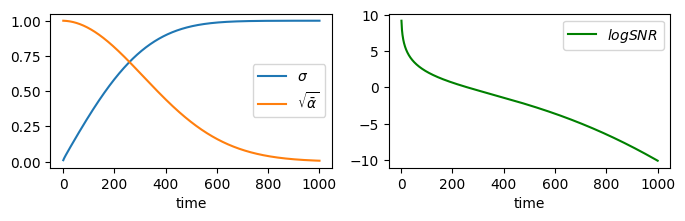

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(4 * 2, 2))

# plot how sqrt_alpha_bar and sigma change over time
ax[0].plot(ts.numpy(), process.sigma(ts), label=r'$\sigma$')
ax[0].plot(ts.numpy(), process.sqrt_alpha_bar(ts), label=r'$\sqrt{\bar\alpha}$')
ax[0].set_xlabel('time')
ax[0].legend()

# It is often helpful to reason in terms of signal-to-noise ratio:
# SNR = sqrt_alpha_bar(t)^2 / sigma(t)^2 or more conveniently, its logarithm.
# High SNR = little noise, low SNR = a lot of noise.
lambda_ = [2. * np.log(process.sqrt_alpha_bar(t) / process.sigma(t)) for t in ts]
ax[1].plot(ts.numpy(), lambda_, c='g', label=r'$log SNR$')
ax[1].set_xlabel('time')
ax[1].legend()

plt.show()

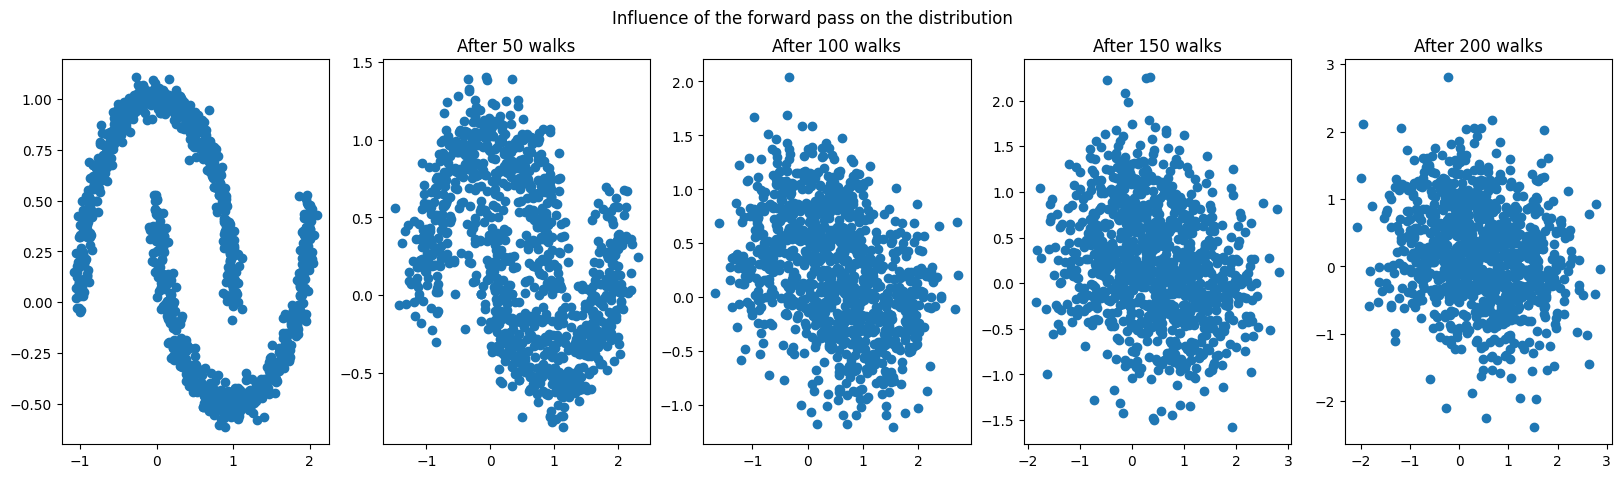

In [12]:
# Effect on the distribution
torch_test_data = torch.Tensor(test_data)
def apply_on_dataset(dataset,t):
    dataset_t = torch.zeros_like(dataset)
    for i in range(dataset.shape[0]):
        point = dataset[i]
        eps = torch.randn_like(point)
        point_t = process.sample(point, t, eps)
        dataset_t[i] = point_t
    return dataset_t

fig,axes = plt.subplots(1,5,figsize=(20,5))
axes[0].scatter(torch_test_data[:,0],torch_test_data[:,1])
for i in range(1,5):
    t = torch.Tensor([i*50]).type(torch.int64)
    dataset_t = apply_on_dataset(torch_test_data,t)
    axes[i].scatter(dataset_t[:,0],dataset_t[:,1])
    axes[i].set_title(f"After {t.detach().item()} walks")
fig.suptitle("Influence of the forward pass on the distribution")
plt.show()



#### Backward Process

Hypothetically, We would like  to train the reverse kernel $p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)$, with parameters $\theta$ parametrized by a neural network

$$
p_\theta\left(\mathbf{x}_{0: T}\right):=p\left(\mathbf{x}_T\right) \prod_{t=1}^T p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)
$$

with $p(\mathbf{x}_T)$ a Gaussian prior, $p(\mathbf{x}_T) \sim \mathcal{N}(0,I)$ . We would use $p(\mathbf{x}_T)$ to sample new data points for generation.

#### Variational Lower Bound

In the paper, they used the knowledge of the forward pass and design a  Gaussian  reverse kernel

$$
p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)=\mathcal{N}\left(\mathbf{x}_{t-1} ; \mu_\theta\left(\mathbf{x}_t, t\right), \Sigma_\theta\left(\mathbf{x}_t, t\right)\right)
$$

with $\mu_{\theta}$ and $\Sigma_{\theta}$  parametrized by a neural network

We can write the previous forward kernel
$$
\begin{aligned}
q\left(\mathbf{x}_t \mid \mathbf{x}_0\right) & =\mathcal{N}\left(\mathbf{x}_t ; \sqrt{\bar{\alpha}_t} \mathbf{x}_0,\left(1-\bar{\alpha}_t\right) \mathbf{I}\right) \\
& =\sqrt{\bar{\alpha}_t} \mathbf{x}_0+\epsilon \sqrt{1-\bar{\alpha}_t}
\end{aligned}
$$
with $ \epsilon \sim \mathcal{N}(0, \mathbf{I})$

The natural loss would be to optimize under the variational lower bound $L_t$ such that :
$$
\begin{aligned}
L_{\mathrm{vlb}} & :=L_0+L_1+\ldots+L_{T-1}+L_T \\
L_0 & :=-\log p_\theta\left(x_0 \mid x_1\right) \\
L_{t-1} & :=D_{K L}\left(q\left(x_{t-1} \mid x_t, x_0\right) \| p_\theta\left(x_{t-1} \mid x_t\right)\right) \\
L_T & :=D_{K L}\left(q\left(x_T \mid x_0\right) \| p\left(x_T\right)\right)
\end{aligned}
$$

One can show that an alternative loss can be used that only take one parametrized estimator $\epsilon_{\theta}$. \
Hint: KL divergences between Gaussian distributions can be computed analytically
$$
L_{\text {simple }}(\theta):=\mathbb{E}_{t, \mathbf{x}_0, \boldsymbol{\epsilon}}\left[\left\|\boldsymbol{\epsilon}-\boldsymbol{\epsilon}_\theta\left(\sqrt{\bar{\alpha}_t} \mathbf{x}_0+\sqrt{1-\bar{\alpha}_t} \boldsymbol{\epsilon}, t\right)\right\|^2\right]
$$

Let's start implementing the network that predicts $\widehat \epsilon(x_t, t; \theta)$. Note that, as stated by its definition, $\epsilon$ is the cumulated noise from $t=0$ and not just the noise added at the last step.

In [13]:
import torch.nn as nn

class ResidualMLP(nn.Module):
    """MLP with residual connections."""

    def __init__(
        self,
        n_blocks: int,
        n_hidden: int,
        n_out: int,
        activation: str,
        name: str = None
    ):
        super(ResidualMLP, self).__init__()
        self._n_blocks = n_blocks
        self._n_hidden = n_hidden
        self._n_out = n_out
        self._activation = getattr(nn.functional, activation)

        self.linear_input = nn.Linear(n_out, n_hidden)
        self.linear_time = nn.ModuleList([nn.Linear(n_hidden, n_hidden) for _ in range(self._n_blocks)])
        self.linear_hidden = nn.Sequential(
    nn.ModuleList([nn.Linear(n_hidden, n_hidden) for _ in range(self._n_blocks)]),
    nn.ModuleList([nn.Linear(n_hidden, n_hidden) for _ in range(self._n_blocks)])
        )
        self.linear_output = nn.Linear(n_hidden, n_out)

    def forward(self, xt: torch.Tensor, time: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(xt)

        for _ in range(self._n_blocks):
            h=self._activation(x)
            h=self.linear_hidden[_][0](h)
            h=h+self.linear_time[_](time)
            h=self._activation(h)
            h=self.linear_hidden[_][1](h)
            x=x+h

        outputs = self.linear_output(x)

        return outputs


#### Time embeddings

As we can see above, the denoiser network needs to get timestep $t$ as an input.

However, feeding integers $t=1, 2, ... T$ into the network will not work.

[Transformers](https://arxiv.org/abs/1706.03762), when faced with the same problem, proposed to embed timesteps into $d$-dimensional vectors of sinusoids:

$$e = [\; \sin(w_1 t) \; \; \cos(w_1 t) \; ... \; \sin(w_{d/2} t) \; \; \cos(w_{d/2} t) \;]$$

with $w_i = 1/ 10000^{\frac{2i}{d}}$.

Here is nice blogpost with more intuition: https://kazemnejad.com/blog/transformer_architecture_positional_encoding/


In [14]:
class SinusoidalTimeEmbedding(nn.Module):
    """Time (positional) embedding as in Transformers."""

    def __init__(self, num_features: int, name: str = None):
        super(SinusoidalTimeEmbedding, self).__init__()
        self._num_features = num_features

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        assert len(inputs.shape) == 1
        half_dim = self._num_features // 2
        e = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        embedding = torch.exp(-e * torch.arange(half_dim).float()).to(device)
        embedding = inputs.view(-1, 1) * embedding
        embedding = torch.cat([torch.cos(embedding), torch.sin(embedding)], dim=-1)
        if self._num_features % 2 == 1:
            embedding = nn.functional.pad(embedding, (0, 1))
        return embedding


Now we need to put the two modules together:

In [20]:
import dataclasses

@dataclasses.dataclass
class NetConfig:
    resnet_n_blocks: int = 2
    resnet_n_hidden: int = 512
    resnet_n_out: int = 2
    activation: str = 'elu'
    time_embedding_dim: int = 512


class Net(nn.Module):
    """Combines MLP and time embeddings."""
    def __init__(self, net_config: NetConfig, name: str = None):
        super(Net, self).__init__()

        self._time_encoder = SinusoidalTimeEmbedding(net_config.time_embedding_dim)
        self._predictor = ResidualMLP(
            n_blocks=net_config.resnet_n_blocks,
            n_hidden=net_config.resnet_n_hidden,
            n_out=net_config.resnet_n_out,
            activation=net_config.activation
        )

    def forward(self, noisy_data: torch.Tensor, time: torch.Tensor) -> torch.Tensor:
        time_embedding = self._time_encoder(time)
        outputs = self._predictor(noisy_data, time_embedding)
        return outputs


#### Time sampler

To compute our loss function, for each example, we need to sample a random timestep. In this trivial case of uniform sampling between step 1 and T, it might be an overkill to implement it as a separate class. It would be more helpful if you're going to explore more exotic diffusion models.

In [16]:
from typing import Sequence

class UniformDiscreteTimeSampler:

    def __init__(self, tmin: int, tmax: int):
        self._tmin = tmin
        self._tmax = tmax

    def sample(self, shape: Sequence[int]) -> torch.Tensor:
        return torch.randint(low=self._tmin, high=self._tmax, size=shape)


#### Full DDPM model

**Q.23 Implement the Simplified loss given a model $\epsilon_{\theta}$**

In [17]:
class DiffusionModel(nn.Module):
    """Diffusion model."""

    def __init__(self, diffusion_process, time_sampler, net_config, data_shape):
        super(DiffusionModel, self).__init__()

        self._process = diffusion_process
        self._time_sampler = time_sampler
        self._net_config = net_config
        self._data_shape = data_shape
        self.net_fwd = Net(net_config)

    def loss(self, x0: torch.Tensor) -> torch.Tensor:
        """Computes MSE between the true noise and predicted noise,
        i.e. the goal of the network is to correctly predict eps from a noisy observation
        xt = alpha(t) * x0 + sigma(t)**2 * eps"""

        ###############
        # TO COMPLETE #
        ###############

        t = self._time_sampler.sample((x0.shape[0],)).to(device) # sample time

        eps = torch.randn_like(x0, device=x0.device) # sample noise
        xt = self._process.sample(x0, t.repeat((x0.shape[1],1)).T, eps) # corrupt the data

        self.net_fwd.train()
        net_outputs = self.net_fwd(xt, t) # get net outputs

        loss_fcn = nn.MSELoss()
        loss = loss_fcn(net_outputs, eps) # compute MSE loss between predicted and true noise

        return loss

    #Used for sampling
    def _reverse_process_step(
        self,
        xt: torch.Tensor,
        t: int,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        """Computes parameters of a Gaussian p_{\theta}(x_{t-1}| x_t)."""

        t = t * torch.ones((xt.shape[0],), dtype=torch.int32, device=xt.device)

        ###############
        # TO COMPLETE #
        ###############

        self.net_fwd.eval()
        eps_pred = self.net_fwd(xt, t) # predict epsilon from x_t

        sqrt_alpha_t = self._process._sqrt_alphas_bar[t.cpu().long()] / self._process._sqrt_alphas_bar[(t-1).cpu().long()] if t[0] > 1 else self._process._sqrt_alphas_bar[t.cpu().long()] # use self._sqrt_alpha_bar
        # sqrt_alpha_t = torch.tensor(1 - self._process._betas[t.cpu().long()], dtype=torch.float32)
        inv_sqrt_alpha_t = bcast_right(1 / sqrt_alpha_t, xt.ndim).to(xt.device)

        beta_t = 1 - sqrt_alpha_t.pow(2)
        beta_t = bcast_right(beta_t, xt.ndim).to(xt.device)

        inv_sigma_t = 1 / self._process._sigmas[t.cpu().long()]
        inv_sigma_t = bcast_right(inv_sigma_t, xt.ndim).to(xt.device)

        mean = inv_sqrt_alpha_t * (xt - (beta_t/inv_sigma_t) * eps_pred)

        # DDPM instructs to use either the variance of the forward process
        # or the variance of q(x_{t-1}|x_t, x_0). Former is easier.
        std = beta_t.sqrt()

        eps = torch.randn_like(xt, device=xt.device) if t[0] > 1 else 0

        return mean, std, eps


    def sample(self, x0, sample_size):
        """To generate samples from DDPM, we follow the reverse process.
        At each step of the chain, we sample x_{t-1} from p(x_{t-1}| x_t, x0_pred) until we get to x_0."""
        with torch.no_grad():
            x = torch.randn((sample_size,) + self._data_shape, device=x0.device) #sample pure noise


            ###############
            # TO COMPLETE #
            ###############
            for t in range(self._process.tmax - 1, 0, -1):
                mean, std, eps = self._reverse_process_step(x, t)
                x = mean + std * eps

        return x

Given the noise obtained by the model $\boldsymbol{\epsilon}_\theta\left(\mathbf{x}_t, t\right)$, you can sample $\mu_{\theta}(\mathbf{x}_t,t)$ in order to get a denoised sample point.
$$
\mu_{\theta}(\mathbf{x}_t,t) = \frac{1}{\sqrt{\alpha_t}}\left(\mathbf{x}_t-\frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \boldsymbol{\epsilon}_\theta\left(\mathbf{x}_t, t\right)\right)
$$


The _reverse_process_step function sample $x_{t-1} \sim p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)$ where
$$
p_\theta\left(\mathbf{x}_{t-1} \mid \mathbf{x}_t\right)=\mathcal{N}\left(\mathbf{x}_{t-1} ; \mu_\theta\left(\mathbf{x}_t, t\right), \Sigma_\theta\left(\mathbf{x}_t, t\right)\right)
$$
and we set $$\Sigma_\theta\left(\mathbf{x}_t, t\right) = \beta_{t}\boldsymbol{I}$$

Thus $$x_{t-1} = \mu_{\theta}(\mathbf{x}_t,t) + \sqrt{\beta_t}\epsilon$$ where $$\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$$

**Q.24 Build the sampling function that allows you from inputs $\mathbf{x}_t$ and $t$ to obtain $\mu_{\theta}(\mathbf{x}_t,t)$ and $x_{t-1}$**

#### Training

In [21]:
from torch import optim

# create the model
diffusion_process = DiscreteDDPMProcess(num_diffusion_timesteps=1000)
time_sampler = UniformDiscreteTimeSampler(diffusion_process.tmin, diffusion_process.tmax)
model = DiffusionModel(diffusion_process, time_sampler, net_config=NetConfig(), data_shape=(2,)).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
# optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.005)

We will use a learning rate scheduler with a warmup. \
You will have to install the library pytorch_warmup with "pip install -U pytorch_warmup": https://github.com/Tony-Y/pytorch_warmup \
Our learning rate schedule will have the following shape.

![Denoisingdiagram](./lr_with_warmup.png)

In [22]:
# pip install -U pytorch_warmup

In [23]:
import pytorch_warmup as warmup

training_steps = 50000

warmup_period=1000 #this is the increasing part of the learning rate schedule
num_steps = training_steps
t0 = num_steps // 1
lr_min = 3e-12
max_step = t0 * 1 + warmup_period #you can also create cycle but we won't touch it here

lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=t0, T_mult=1, eta_min=lr_min)

warmup_scheduler = warmup.LinearWarmup(optimizer, warmup_period)


##### Training loop

**Q.25 Train $\epsilon_{\theta}(\mathbf{x},t)$ that take as entry a transformed vector $\mathbf{x}$ and  $t$ a number of time $\mathbf{x}$ passed through the forward process  and return  a direct estimate of  the noise $\epsilon$**

Step: 0, Loss: 1.04615


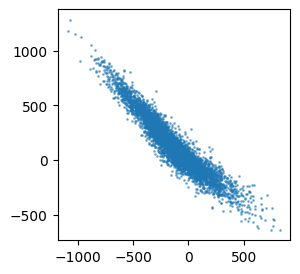

Step: 1000, Loss: 0.20049
Step: 2000, Loss: 0.18817
Step: 3000, Loss: 0.17326
Step: 4000, Loss: 0.17371
Step: 5000, Loss: 0.18868
Step: 6000, Loss: 0.16957
Step: 7000, Loss: 0.18022
Step: 8000, Loss: 0.18173
Step: 9000, Loss: 0.16766
Step: 10000, Loss: 0.17905


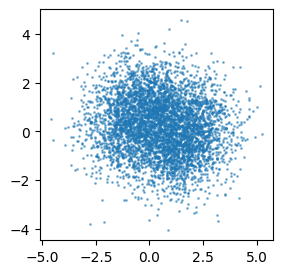

Step: 11000, Loss: 0.17415
Step: 12000, Loss: 0.17415
Step: 13000, Loss: 0.16867
Step: 14000, Loss: 0.17294
Step: 15000, Loss: 0.19779
Step: 16000, Loss: 0.16586
Step: 17000, Loss: 0.16838
Step: 18000, Loss: 0.17811
Step: 19000, Loss: 0.15871
Step: 20000, Loss: 0.17294


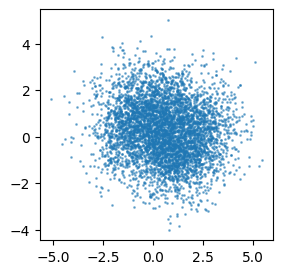

Step: 21000, Loss: 0.17771
Step: 22000, Loss: 0.16749
Step: 23000, Loss: 0.16212
Step: 24000, Loss: 0.17070
Step: 25000, Loss: 0.17858
Step: 26000, Loss: 0.20222
Step: 27000, Loss: 0.16984
Step: 28000, Loss: 0.17528
Step: 29000, Loss: 0.19383
Step: 30000, Loss: 0.18930


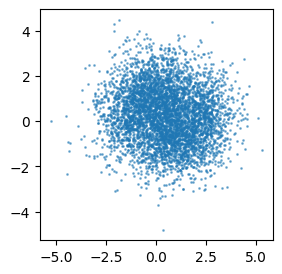

Step: 31000, Loss: 0.16881
Step: 32000, Loss: 0.16543
Step: 33000, Loss: 0.16534
Step: 34000, Loss: 0.17645
Step: 35000, Loss: 0.14738
Step: 36000, Loss: 0.20235
Step: 37000, Loss: 0.18521
Step: 38000, Loss: 0.17372
Step: 39000, Loss: 0.15672
Step: 40000, Loss: 0.18130


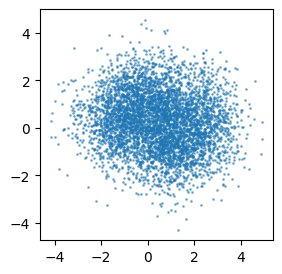

Step: 41000, Loss: 0.16150
Step: 42000, Loss: 0.17863
Step: 43000, Loss: 0.17369
Step: 44000, Loss: 0.16129
Step: 45000, Loss: 0.18666
Step: 46000, Loss: 0.16336
Step: 47000, Loss: 0.15591
Step: 48000, Loss: 0.18005
Step: 49000, Loss: 0.18755


In [24]:
BATCH_SIZE=1024

for step in range(training_steps):
    #generate batch on the fly

    ###############
    # TO COMPLETE #
    ###############
    x0 = generate_batch(BATCH_SIZE).to(device)
    optimizer.zero_grad()
    loss = model.loss(x0)
    loss.backward()
    optimizer.step()

    if step % 1000 == 0:
        print(f'Step: {step}, Loss: {loss:.5f}')

    if step % 10000 == 0:
        with torch.no_grad():
            samples = model.sample(x0, 5000) # create new samples
        plt.figure(figsize=(3, 3))
        plt.scatter(samples.cpu()[:, 0], samples.cpu()[:, 1], s=1, alpha=0.5)
        plt.show()

    with warmup_scheduler.dampening():
        if warmup_scheduler.last_step + 1 >= warmup_period:
            lr_scheduler.step()
        if warmup_scheduler.last_step + 1 >= max_step:
            break


#### Ablation study

**Q.26 Perform ablations experiments on hyperparameters, such as: learning rate (try constant learning rate with different values), batch size, the number of timesteps, the positional embedding for timestep (remove it), the hidden size, number of epochs, skip connections**

For a given ablation experiment (they ought to be done separately!), you should plot generated samples at few given timesteps (if compute resources is limited, do it for one timestep).

Note: you don't have to do all of these experiments, but the bigger is your group, the more you should do.

We tried with learning rates of $3 \times 10^{-4}$, $6 \times 10^{-4}$ and $10^{-3}$ but the behaviour of the loss did not change. The loss is blocked around 0.15-0.20 and does not go lower.
We also tried different values of batch size in $\{256, 1024, 2048\}$ and different values for hidden size of the MLP ($256$ or $512$) but our model still struggles to learn how to predict the adequate noise.

As far as we have been able to check, we think that our architecture of training and denoising is similar to the one proposed in the DDPM paper but we do not understand why we do not manage to retrieve good generation of samples, as shown later in the next cell. There might be an issue that we did not manage to see when troubleshooting our model.

#### Generation/Sampling

**Q.27  Generate samples and plot them at different timestep of the chain. Check how real & synthetic distribution overlap, compare the densities**

As we can see during the training phase, the loss does not go below 0.15 and this is a consequent loss compared to the range of what we try to predict as it follows a normal distribution. Therefore our model struggles to learn and that is why it does not deliver good generalization properties.

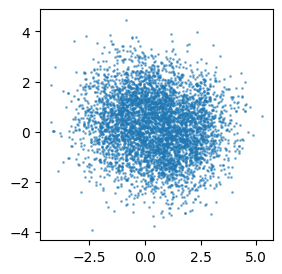

In [25]:
with torch.no_grad():
    x0 = generate_batch(BATCH_SIZE).to(device)
    new_samples = model.sample(x0, 5000)

    plt.figure(figsize=(3, 3))
    plt.scatter(new_samples.cpu()[:, 0], new_samples.cpu()[:, 1], s=1, alpha=0.5)
    # plt.xlim(-1, 2)
    # plt.ylim(-0.5, 1)
    plt.show()

---
### Conclusion

**Q.28: As a conclusion, how would you compare the advantages and shortcomings of GANs, VAEs, Normalizing flows and Denoising Models ?**

In this notebook we only implemented VAEs and Denoising Models, and comparing the two we can say that:

- In a sense they share some similarities. Both approaches try to encode the data relying on a probabilistic function $q$ to endode the data and another one $p$ to decode the data. The difference is that in VAEs, the encoder function is learnable while it is not in the DDPM original paper (even though the variance schedule of the diffusion process can be learn). Moreover, in VAEs we encode the data in a lower representation space while in Denoising Models we seek to reach a normal distribution to encode the data. In this framework, the decoder will denoise the normal distribution to retrieve samples from the original distribution while in VAEs the decoder needs to use the compact information and increase the dimension to retrieve the original distribution.
- Consequently, one advantages of VAEs over Denoising Models is that it can surely be more robust for high dimensional data distributions. Indeed, the encoded space of VAEs has low dimension while encoded space of Denoising Models is gaussian noise that has the same dimensionality as the input. Therefore it can be more prone to the curse of dimensionality or issues happening in high dimensional space.
- On the other hand, encoded space of VAEs might be difficult to interpret while Denoising Models offers an intuitive approach to generate new samples, it learns how to construct samples from noise.
- Both approaches highly depend on the loss and the complexity of the data distribution that need to be learnt and generated afterwards.